# Modeling

To run this tutorial, you should install X-PSI with the default (blackbody) atmosphere extension module, which is compiled when installing X-PSI with default settings. Some data files are needed and they can be found in the [Zenodo](https://zenodo.org/record/7094144).

In [1]:
%matplotlib inline

import os
import numpy as np
import math
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 1.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


Let's build a generative model for the data; first we build a *callable* object for likelihood evaluation, and then we build a *callable* object for prior-density evaluation.

En route, we will explain why various software design choices were made during development. In some cases the conventions defined are not necessarily important for future development and indeed we expect them to be redesigned.

## Likelihood

If you have not yet read the [likelihood overview](overview.rst), it is advisable to do so now, or refer to a paper such as [Riley et al. (2019)](applications.rst#riley-et-al-2019-apjl-887-l21).

### The parameter space

In order to implement an X-PSI likelihood function it is first necessary to define an underlying model parameter space. In general the parameter space is $\mathbb{R}^{d}$, where $d\in\mathbb{N}$ is the total number of free model parameters. Each free parameter is an instance of the [Parameter](parameter.rst#xpsi.Parameter.Parameter) class. We also support fixed (or frozen) variables and *derived* variables that are deterministic functions of other variables (notably, free parameters). 

In X-PSI we build upon a base class representing a [ParameterSubspace](parameterSubspace.rst#xpsi.ParameterSubspace.ParameterSubspace). To construct an X-PSI model a set of objects are defined which *derive* from this parameter subspace, and it is the *union* of these objects that forms both the global model parameter space, and a set of methods and attributes for evaluation of a parametrised sampling distribution of the data at the vector $\mathcal{D}$, conditional on a vector of model parameter values.

Our aim is to construct a *callable* ``likelihood`` object to feed as a *callback* function to a posterior sampler and a posterior integrator. We illustrate this object in the diagram below; all nodes in the diagram below represent objects (instances of some class). In some cases there are multiple instances of a particular class, in other cases there is only a single instance of a particular class. Moreover, a subset of these classes inherit from (subclass) [ParameterSubspace](parameterSubspace.rst#xpsi.ParameterSubspace.ParameterSubspace), because instances of these classes are objects with a parameter subspace and a collection of methods with instructions for handling parameter vectors in that subspace (methods and attributes to, e.g., calculate and store some *derived* quantities of the underlying theory/model respectively for likelihood evaluation).

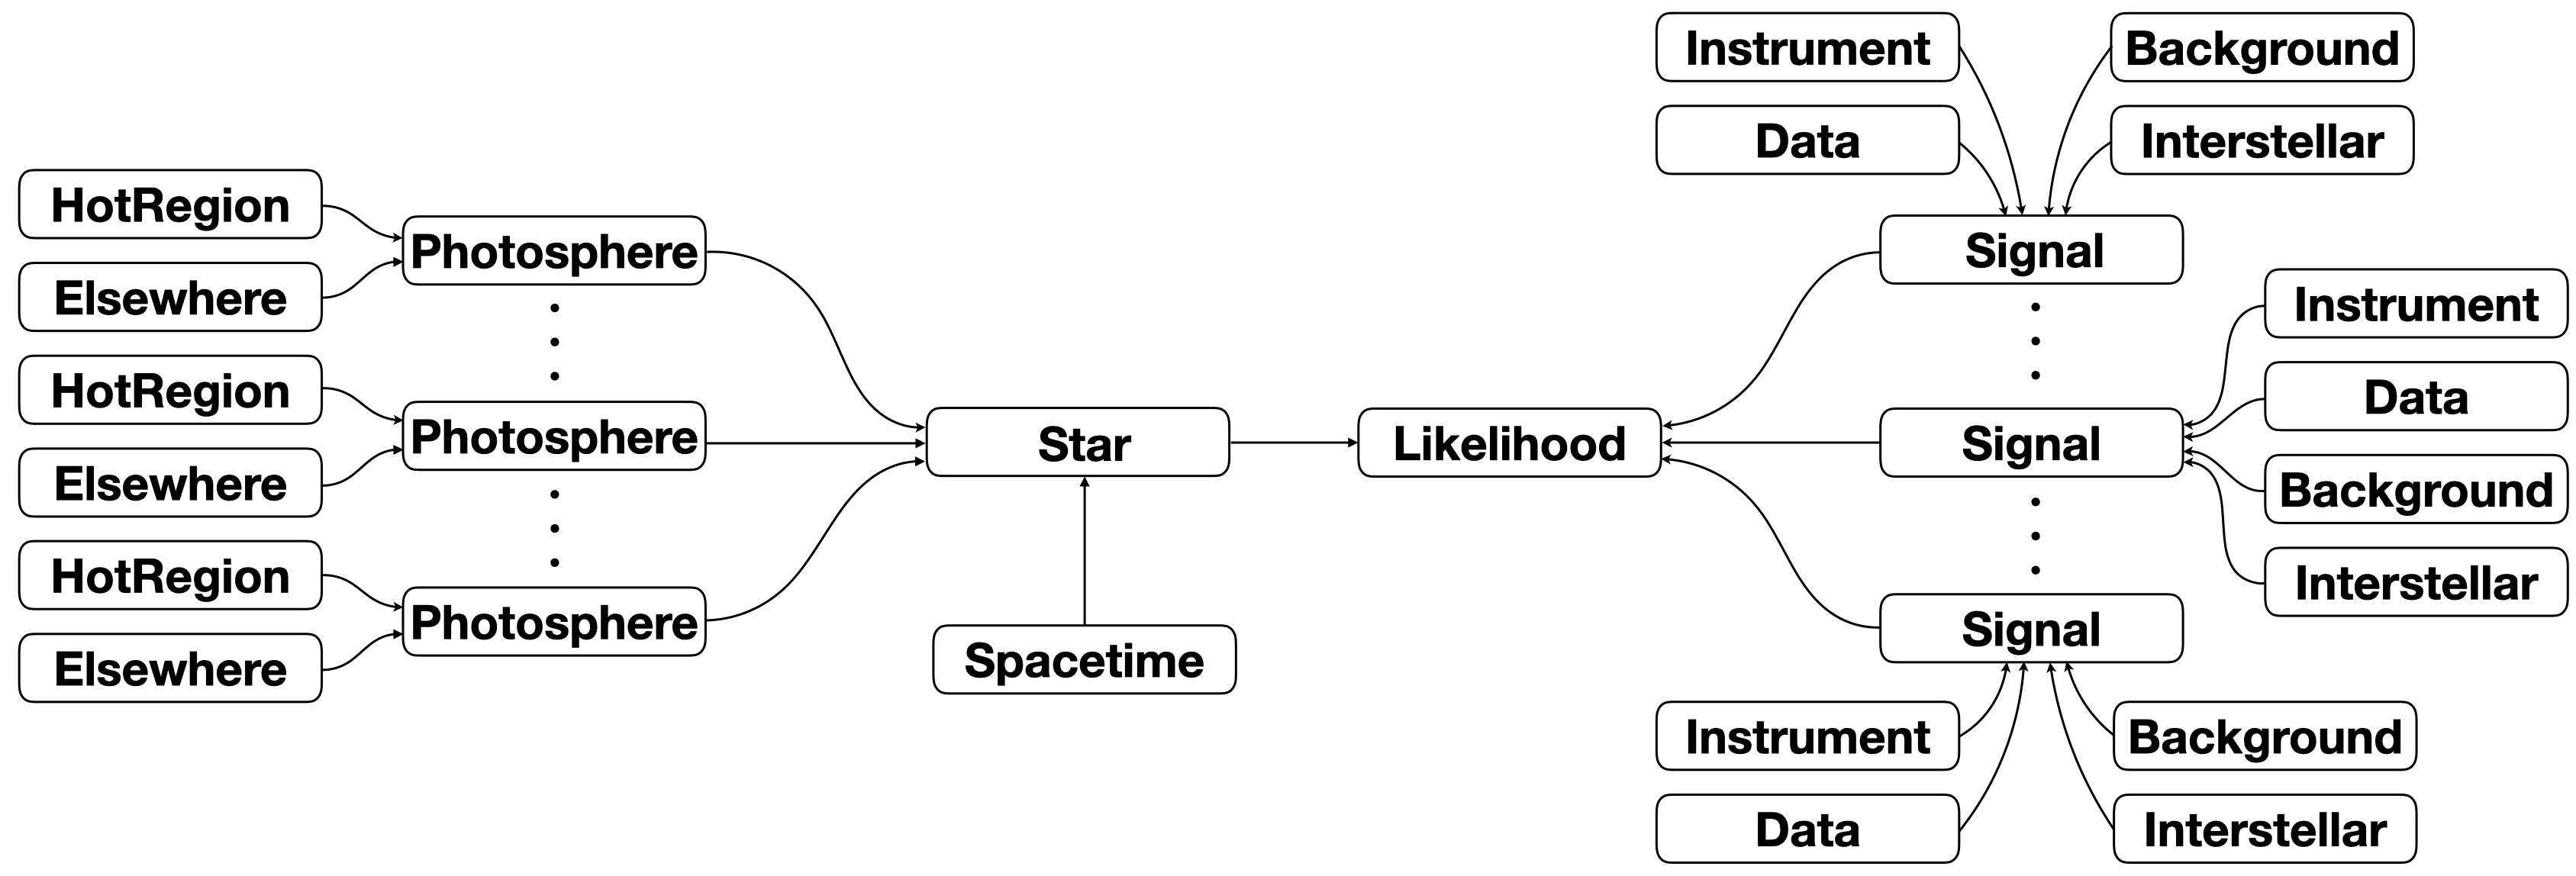

In [2]:
from IPython.display import Image
Image("./_static/oop_modelling_diagram_v1.png")

The arrows in the diagram denote an object that is stored as an attribute of another encapsulating (a reference to) another object. When a call is processed to evaluate the likelihood given a vector of model parameter values, encapsulating objects get attributes (magically including method calls) of the wrapped objects. The likelihood call results in a cascade of attribute lookups by objects higher in the hierarchy to those lower in the hierarchy. An arguably powerful aspect of the implementation is the merging of parameter subspaces when references to two or more subspaces are encapsulated with an object higher in the hierarchy. This permits parameters to be accessed via Python container ``__getitem__`` and ``__setitem__`` magic on any object (deriving from ``ParameterSubspace``) that encapsulates references to them.

We will now briefly describe the purpose of each object above which is encapsulated by the callable ``likelihood`` object (``Likelihood`` in the diagram to denote the name of the class of which it is an instance). Note the use of the term *abstract base class*, which means that a user is required to subclass, and thereby provide a concrete implementation of some functionality specific to their model. Some source code classes are concrete classes that can be instantiated directly.

* A ``Star`` instance derives from the ``ParameterSubspace`` class. It represents the model star. The objects it encapsulates also derive from the ``ParameterSubspace`` class.
    * A ``Spacetime`` instance derives from the ``ParameterSubspace`` class. It represents the ambient Schwarzschild spacetime solution.
    * A ``Photosphere`` instance derives from the ``ParameterSubspace`` class. It represents a radiation field on a 2-surface embedded in a spacelike hypersurface of that ambient spacetime. There can be multiple ``Photosphere`` instances per ``Star`` instance, naturally representing *snapshots* in time that are assumed to be adequate approximations for some natural number of stellar rotations. Note that the dimensionality of the parameter space grows linearly, however, so in practice this approximation to time evolution is intended for simulation and data synthesis.
        * A ``HotRegion`` instance derives from the ``ParameterSubspace`` class. It represents a radiatively intense region: e.g., a "circular hot-spot" in the photosphere (the surface radiation field). Alternatively, a ``TwoHotRegions`` object that derives from ``HotRegion``, or a ``HotRegions`` object that encapsulates references to two or more ``HotRegion`` instances, is used.
        * An ``Elsewhere`` instance derives from the ``ParameterSubspace`` class. The represents the surface radiation field exterior to the hot region.
        * An ``Everywhere`` instance derives from the ``ParameterSubspace`` class. The represents the surface radiation field *everywhere*, and *cannot* be used in conjuction with ``HotRegion`` instances and ``Elsewhere`` instances.
* A ``Signal`` instance derives from the ``ParameterSubspace`` class, and is itself an abstract base class. A signal is defined as a subset   $\mathcal{D}_{i}\subseteq\mathcal{D}$ of the dataset with a parametrised sampling distribution dependent on an
  incident specific flux signal generated by a particular ``Photosphere`` instance. There can thus be multiple
  ``Signal`` instances.
    * A ``Data`` instance does *not* derive from the ``ParameterSubspace`` class, and is a concrete class. It is a container
     for the data subset $\mathcal{D}_{i}\subseteq\mathcal{D}$.
    * An ``Instrument`` instance derives from the ``ParameterSubspace`` class, and is a concrete class. It represents the model instrument for transforming incident specific flux signals into a structure which directly
      enters the parameterised sampling distribution of $\mathcal{D}_{i}$.
    * An ``Interstellar`` instance derives from the ``ParameterSubspace`` class, and is itself an abstract base class. It represents
      a model for physical interstellar radiation-matter interaction processes which modify the surface radiation
      field during propagation to the instrument.
    * A ``Background`` instance derives from the ``ParameterSubspace`` class, and is itself an abstract base class. It represents a
      model for the background radiation field *incident* on the instrument.

The purpose of invoking the object-oriented paradigm here is to organise a non-trivial likelihood evaluation algorithm in a *logical*, *flexible*, and *extensible* manner by identifying groups of mathematical structures which can be considered as belonging to some more abstract object with some physical and/or statistical meaning, and *modularising* them in classes.

We use a dynamic and expressive high-level language to organise this computation, allowing both calls low-level library routines where necessary to improve calculation speed, and straightforward communication between our problem-specific code and other more general open-source software libraries (in particular, statistical sampling software).

As stated above, for each of these objects which derive from the ``ParameterSubspace`` class, their parameter subspaces are merged into a higher-dimensional space when referenced by an object higher in the hierarcy. As an example, a ``HotRegion`` instance and an ``Elsewhere`` instance each have an associated parameter subspace, and those are merged to form most of the dimensions of the parameter space associated with a ``Photosphere`` instance.

Note that one can in principle utilise a given object multiple times. An example would be the use of the same ``Instrument`` object or ``Interstellar`` processes object for constructing multiple ``Signal`` objects, although this might result in too many parameter dimensions for a problem to be tractable. On another level, the instruments might reference some of the same ``Parameter`` objects, but themselves be distinct objects, each passed to a distinct ``Signal`` object. In the diagram below we illustrate a *tied* relationship between some objects with connecting lines: this could mean the tied objects are *the same* object, or that the objects share some parameters, or that properties of one are derived from the free parameters of another.

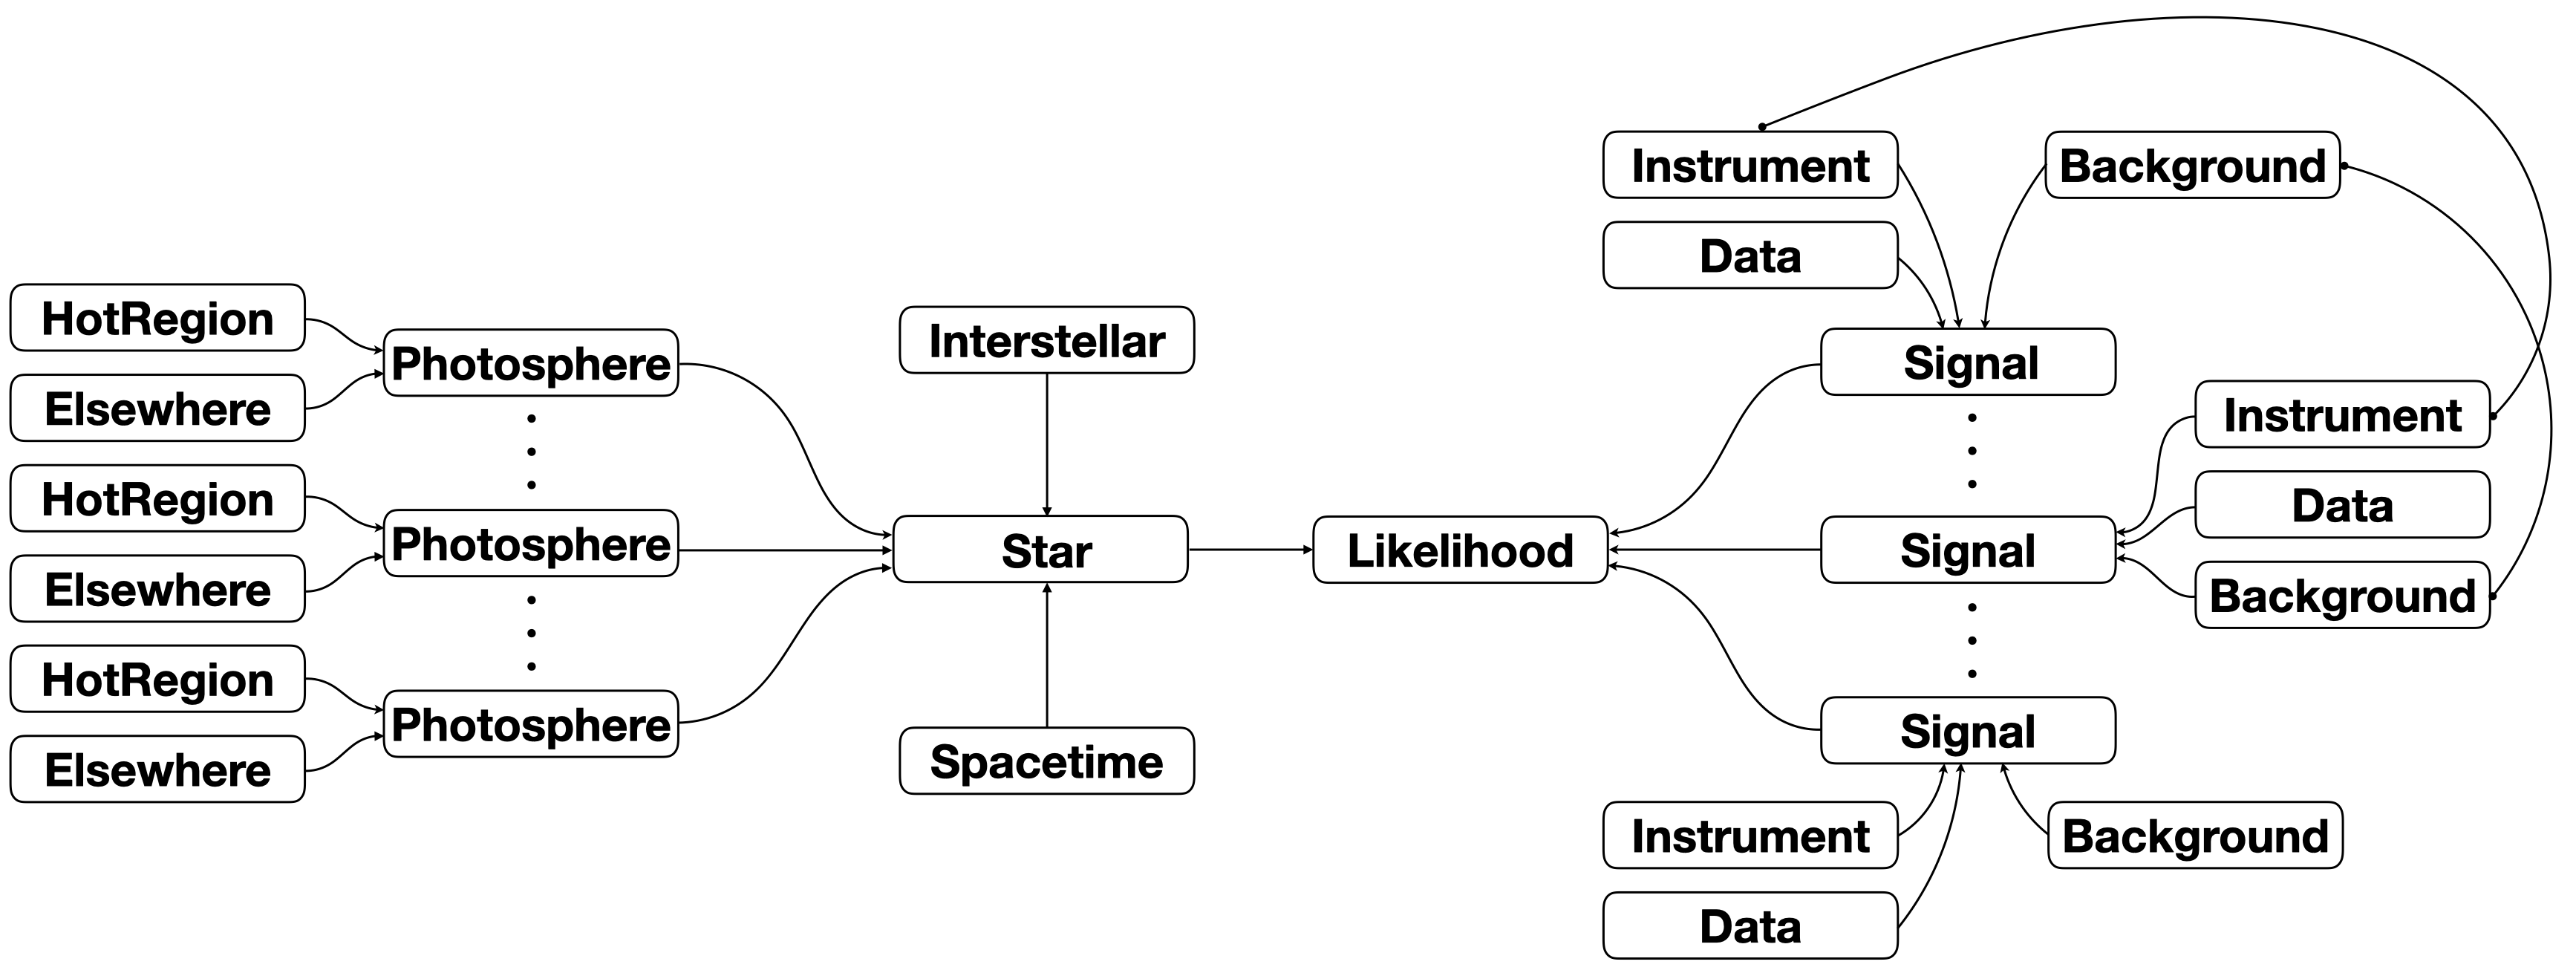

In [3]:
Image("./_static/oop_modelling_diagram_v2.png")

In this case, the tied objects represent physical systems or processes exisiting at different times, but some behaviour is shared. Note that we also assumed that the ``Interstellar`` processes are time-invariant and thus moved the object over to connect to the ``Star`` itself; the source code is not structured quite in this way, but achieves the same if an ``Interstellar`` process object is time-invariant. The ``Data`` objects are never parametrised and thus are not tied in the sense discussed above.

Another example might be supplying the same hot-region radiation field parameters to two *disjoint* hot regions that simultaneously occupy a subset of the stellar surface. In this case the ``Parameter`` objects referenced in the ``HotRegion`` objects would be shared. Another way to achieve the same effect is to define parameters of one hot region as *derived* from those of the other hot region. Both methods would achieve the same goal, but would be implemented differently. The latter is more flexible and thus more powerful. More extensive examples of this paradigm are given in a separate tutorial.

If there are instantaneously multiple *disjoint* surface hot regions, the model object hierarchy diagram would more accurately be rendered as:

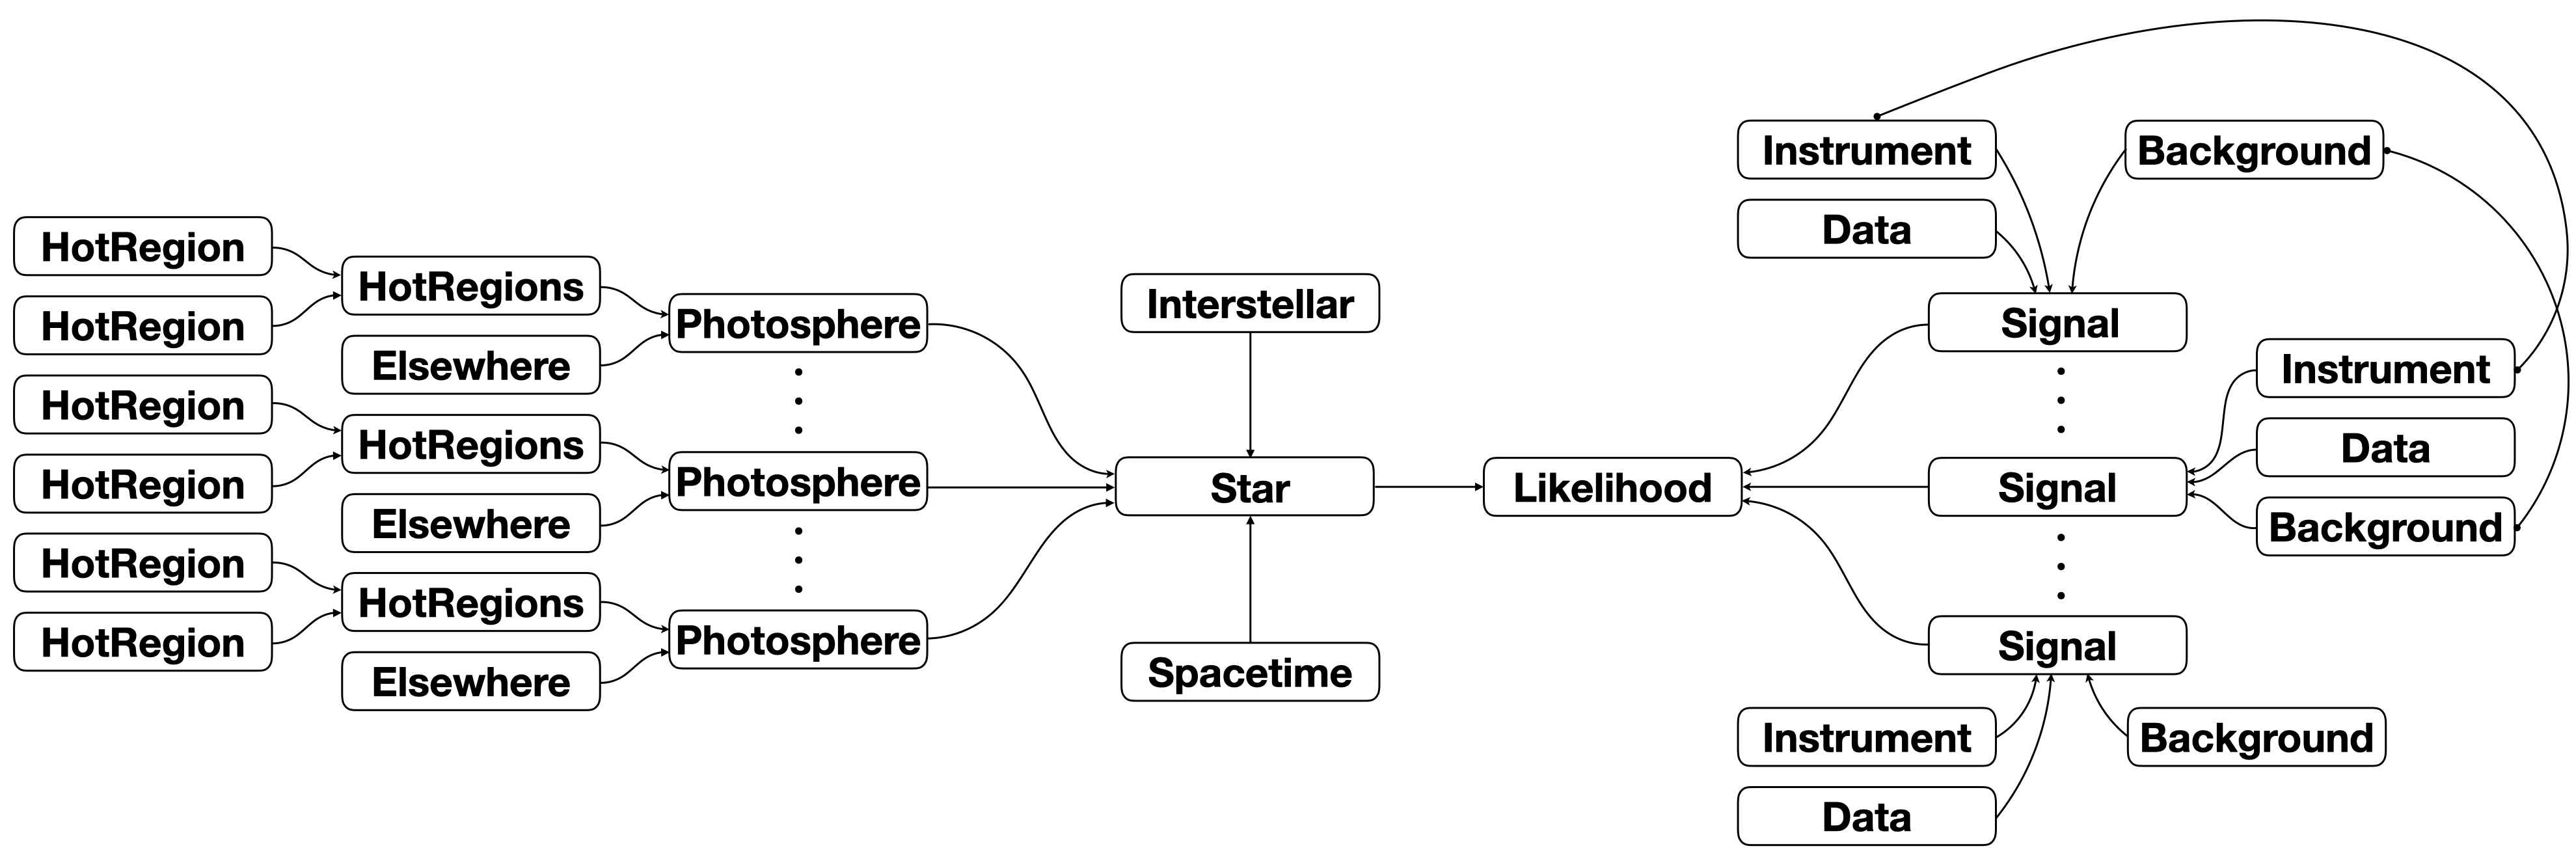

In [4]:
Image("./_static/oop_modelling_diagram_v3.png")

If there are multiple instances of the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class, and multiple instances of the [Signal](signal.rst#xpsi.Signal.Signal) class with a one-to-one mapping, the parameter set would assume the following form:

* coordinate spin frequency
* (rotationally deformed) gravitational mass
* coordinate equatorial radius
* distance from Earth
* inclination of Earth to stellar rotation axis
* ``photosphere_1`` (non-optional):
    * coordinate rotation frequency of a mode of radiative asymmetry assumed to generate the observed pulsations
    * subvector of geometric hot-region parameters (e.g., spot centre colatitude, spot angular radius, and so on) and a parameter controlling the surface local-comoving-frame radiation field *within* the region boundaries
    * (optional) subvector of additional parameters controlling the surface local-comoving-frame radiation field *within* the hot-region boundaries (e.g., pertaining to ionisation degree or composition)
    * (optional) subvector of parameters controlling the surface local-comoving-frame radiation field *outside* the hot-region boundaries
    * subvector of fast parameters for the phases of the hot region(s) relative to some fiducial phase
* $\ldots$
* ``photosphere_n`` (optional):
    * coordinate rotation frequency of a mode of radiative asymmetry assumed to generate the observed pulsations
    * subvector of geometric hot-region parameters (e.g., spot centre colatitude, spot angular radius, and so on) and a parameter such as an effective temperature controlling the surface local-comoving-frame radiation field *within* the region boundaries
    * (optional) subvector of additional parameters controlling the surface local-comoving-frame radiation field *within* the hot-region boundaries (e.g., pertaining to ionisation degree or composition)
    * (optional) subvector of parameters controlling the surface local-comoving-frame radiation field *outside* the hot-region boundaries
    * subvector of fast parameters for the phases of the hot region(s) relative to some fiducial phase
* ``signal_1`` (non-optional):
    * (optional) subvector of fast nuisance parameters associated with interstellar processes
    * (optional) subvector of fast nuisance parameters associated with instrument response
    * (optional) subvector of fast nuisance parameters associated with background processes
* $\ldots$
* ``signal_n`` (if matching ``photosphere_n``):
    * (optional) subvector of fast nuisance parameters associated with interstellar processes
    * (optional) subvector of fast nuisance parameters associated with instrument response
    * (optional) subvector of fast nuisance parameters associated with background processes
    
where $\forall i\in[1,n]$ ``photosphere_i`` and ``signal_i`` share an identification ``tag``.

Most model parameters that are *not* associated with ``Signal`` instances are considered *slow* parameters; see the interlude below for definition of *slow* and *fast*. An example of a *slow* parameter is the gravitational mass, whilst examples of *fast* parameters are the initial phase of the photosphere and the distance (from Earth) to the star.

Yet another paradigm is that the same signal yielded by integrating over the photosphere is operated on by multiple instruments (on different telescopes or the same telescope, or some on one telecope and others on other telescopes), and because these instruments are synergystic probes of the physical signal-generating process, we aim to jointly model the data from those instruments. This can be executed as follows:

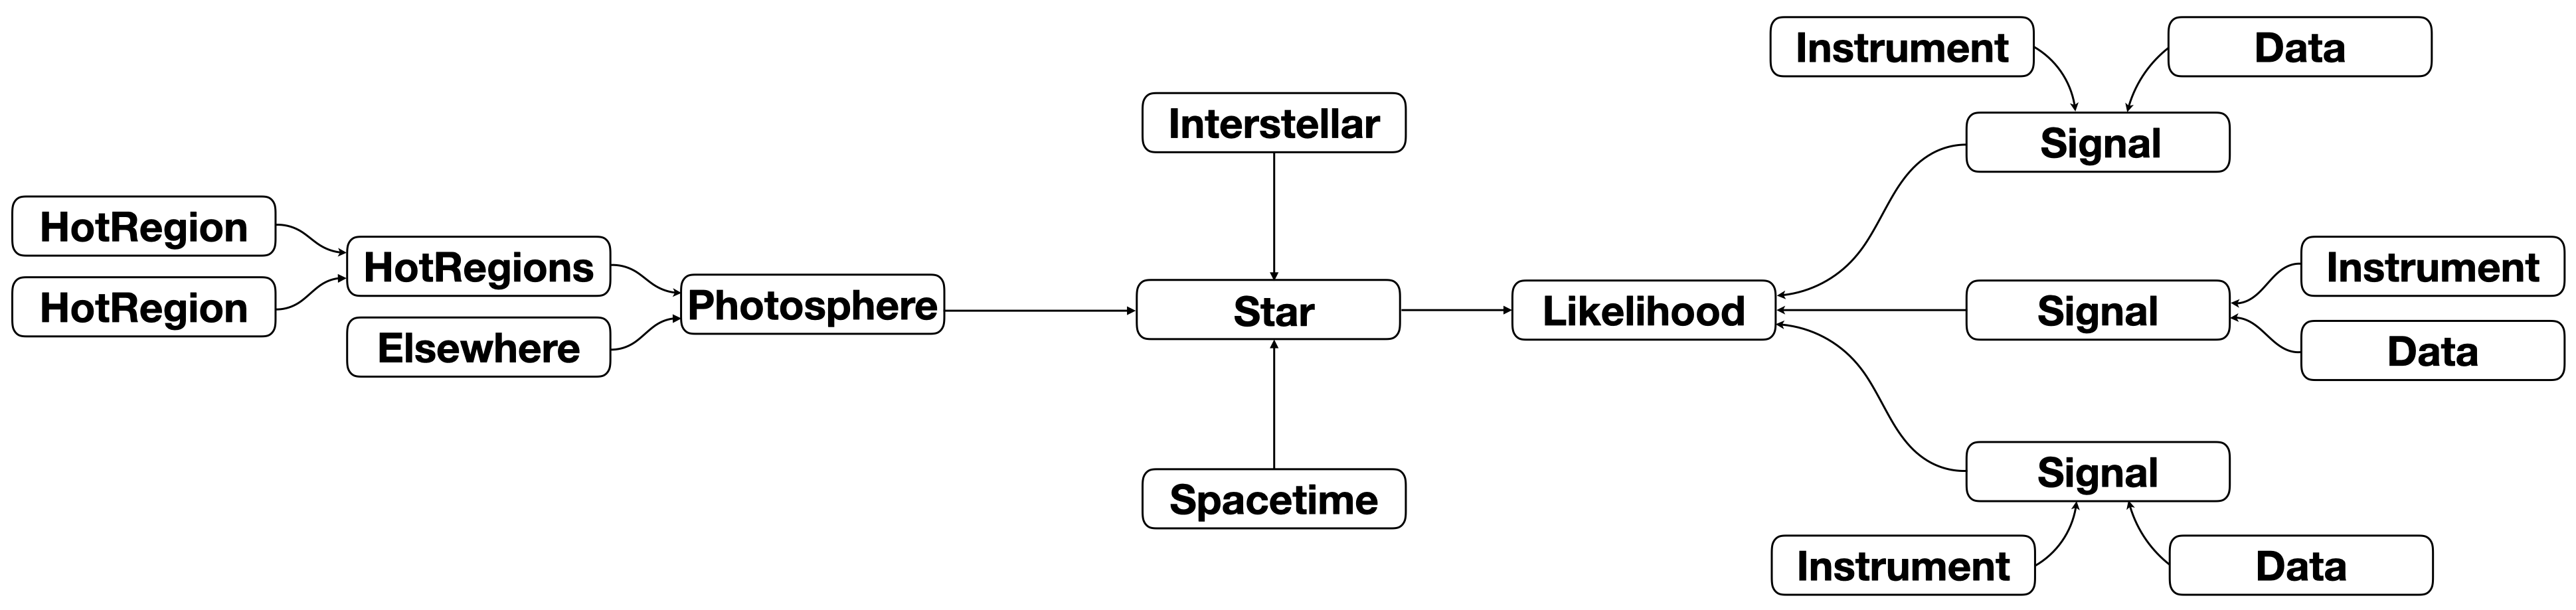

In [5]:
Image("./_static/oop_modelling_diagram_v4.png")

Here the signal from integrating over the image of the ``Photosphere`` instance is relayed to all ``Signal`` instances for instrument operation and likelihood function calculation. The signal relayed is always encapsulated by a 2D NumPy array with photon energy increasing with row (zeroth dimension) and phase increasing with column (first dimension). Even if an integrator (extension module) is called that assumes time-invariance of the image of the ``Photosphere`` and thus returns a single spectrum, that spectrum is encapsulated by a 2D NumPy array. Specifically, an ``Elsewhere`` instance returns a spectrum which is added to the spectrum at each phase generated by the associated ``HotRegion(s)`` instance. The user can then completely phase-average the signal (thus generating a single spectrum) for comparison to an instrument whose registered (and pre-processed) data is a spectrum. For instruments that register time-resolved data, the user will usually integrate the signal phase intervals (bins) for likelihood function evaluation. The phase-resolved and phase-averaged data can be jointly modeled.

Finally, one can use ``Everywhere`` instances to model the surface radiation field everywhere, but these instances cannot be used in conjuction with ``HotRegion`` instances nor ``Elsewhere`` instances to constitute the same ``Photosphere`` instance. An example of this paradigm is as follows:

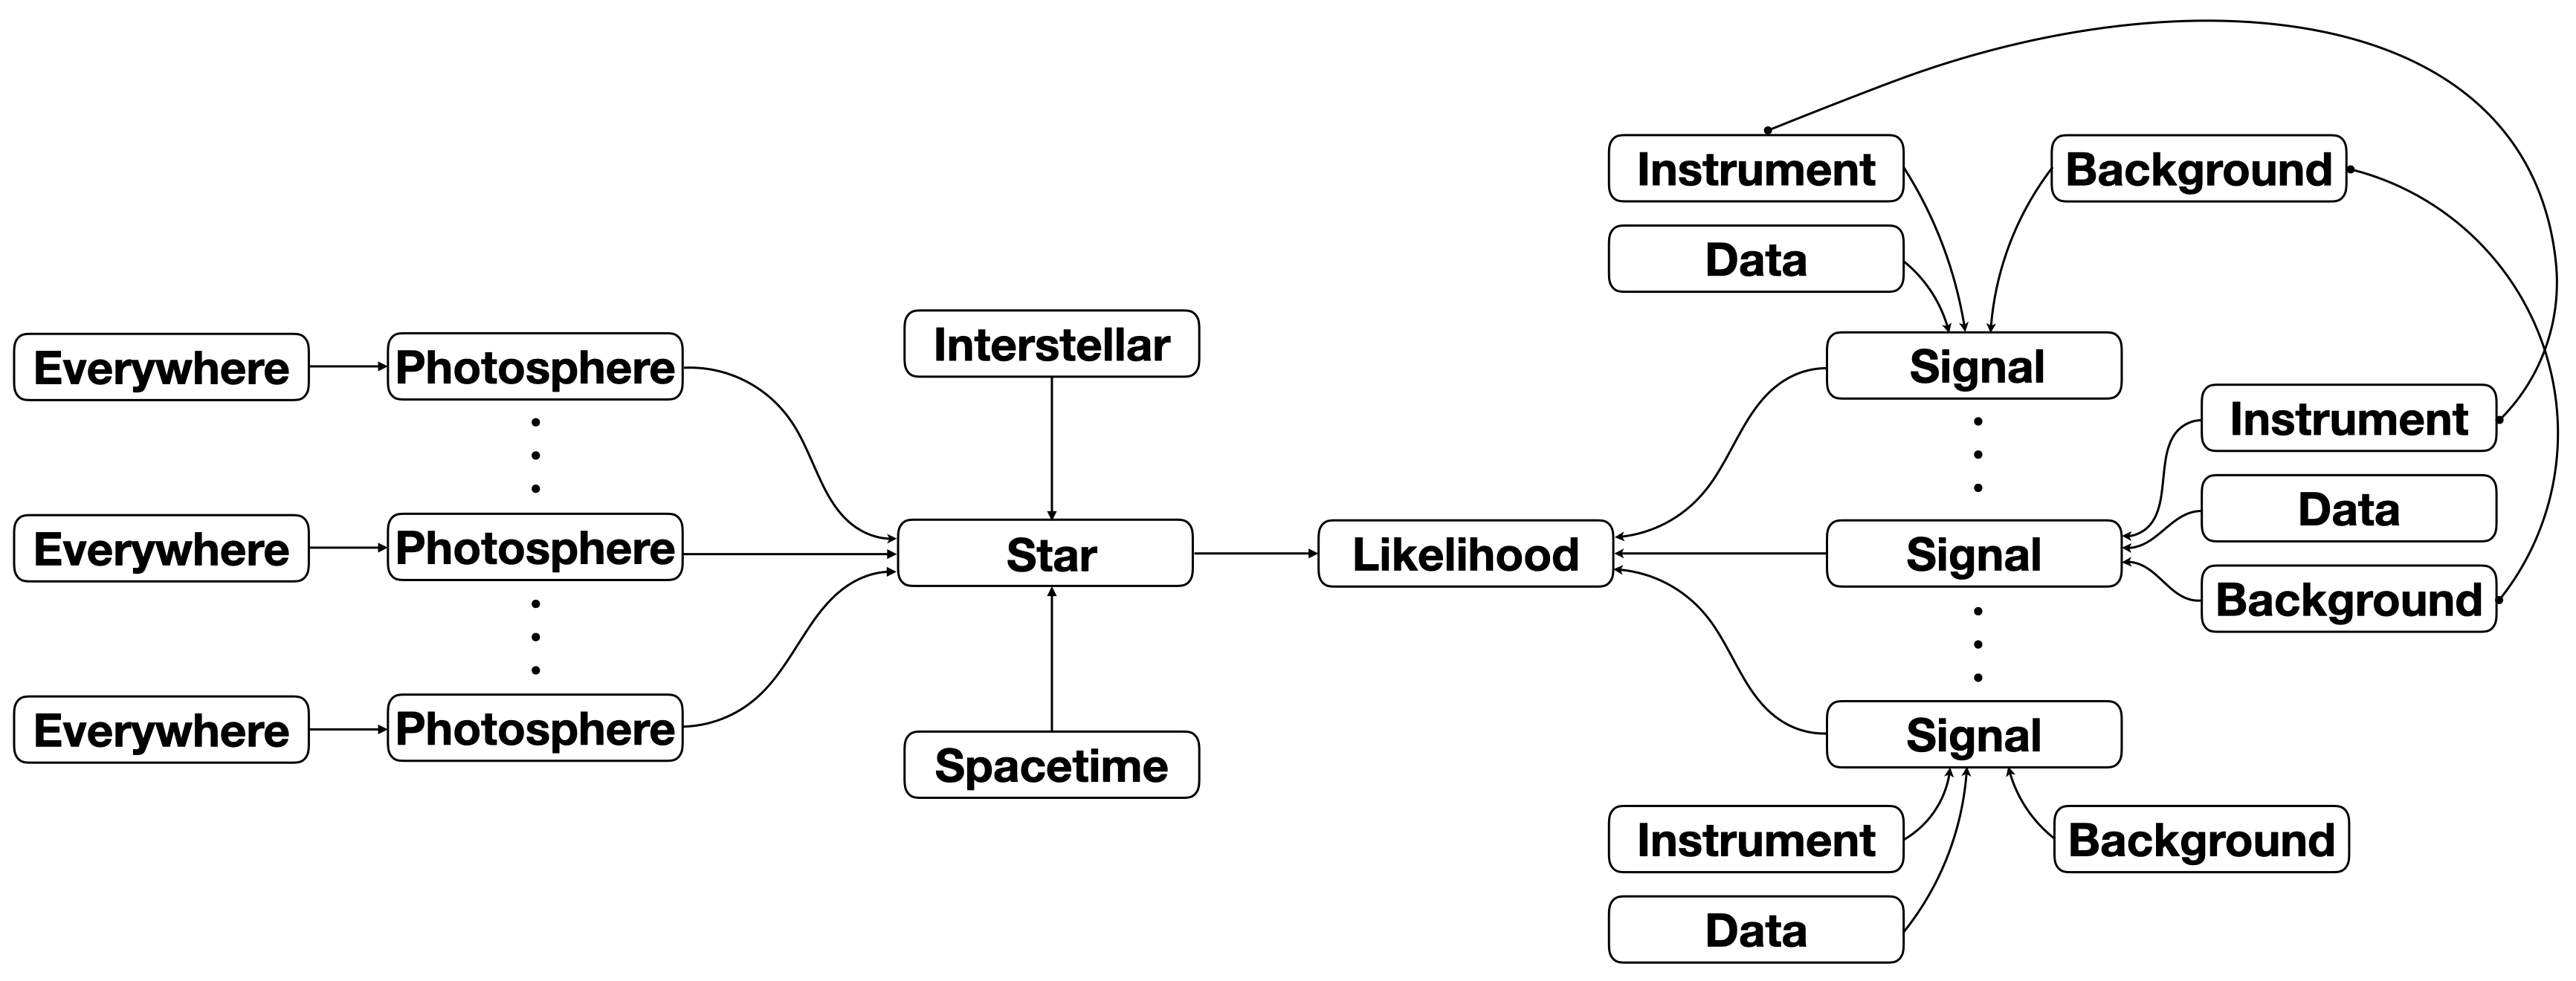

In [6]:
Image("./_static/oop_modelling_diagram_v5.png")

Note that here we chose to return to the notion of time-evolution between ``Photosphere`` instances, instead of using multiple ``Signal`` intances operating on one ``Photosphere`` instance.

### Interlude: fast and slow parameters

A subset of model parameters are *slow* because varying those parameters requires *likelihood* re-evaluation, and the compute time required to perform that re-evaluation is slow *relative* to re-evaluation when varying only a distinct *subset* of the model parameters: the *fast* parameters. In general there can be multiple subsets of parameters forming a *speed hierarchy*; see [A. Lewis, "Efficient sampling of fast and slow cosmological parameters" (arXiv:1304.4473)](https://arxiv.org/abs/1304.4473).

X-PSI, during developement, supported the use of the nested sampler PolyChord, whose internals require that parameters forming a speed hierarchy are ordered in subsets (or blocks) from *slow* to *fast* in an array passed to a ``likelihood`` callback function (if one wishes to exploit a speed hierarchy that is). Thus the ordering of an array of parameter values passed to a general instance of the [Likelihood](likelihood.rst#xpsi.Likelihood.Likelihood) class was of crucial importance. During development, we opted to support the nested sampler MultiNest instead based on the nature of the sampling problem (dimensionality and likelihood evaluation expense).

However, until X-PSI ``v0.3``, a convention for parameter ordering for likelihood evaluation was imposed, with two basic speed grades. In ``v0.3``, however, we do not adhere to a speed hierarchy for lack of an application at present, although with some added sophistication this can be supported.

### Data

For the analysis in this notebook we consider all data $\mathcal{D}$ to be drawn from a joint sampling distribution whose dependency on *slow* model source parameters is expressed in terms of a *single* pulse signal. The justification for such an assumption is that we are performing parameter estimation given a synthetic data set for a model *pulsar* with a stable (effectively non-evolving) surface radiation field, with any quasi-periodicity arising solely from relative orbital motion of source and telescope. The synthetic data is intended to emulate detection of photons over a long observing run, after which the photon incidence events are phase-folded during a pre-processing phase.

This parameter estimation excercise is not *blind*: we know the parameter values injected to generate the synthetic dataset we will later load into a custom container.

We do not need to subclass data container, but you can if you wish. X-PSI is designed this way because there is a clear common usage pattern that can be concretely implemented whilst preserving the freedom and the scope of applicability of the source code. The container instance will be available as an underscore instance method of [Signal](signal.rst#xpsi.Signal.Signal), and thus available in a derived class where we will later write code for likelihood evaluation.

Hereafter we will write our custom derived classes in the notebook itself, but in practice it is best if your derived classes are written in distinct modules within a project directory, so they can be imported by a script for use with an MPI command within a shell (because in general we want to exploit parallelism for expensive likelihood evaluations).

Let us load a synthetic data set that we generated in advance, and know the fictitious exposure time for:

In [7]:
settings = dict(counts = np.loadtxt('../../examples/examples_modeling_tutorial/model_data/example_synthetic_realisation.dat', dtype=np.double),
                channels=np.arange(20,201),
                phases=np.linspace(0.0, 1.0, 33),
                first=0, last=180,
                exposure_time=984307.6661)

data = xpsi.Data(**settings)

Setting channels for event data...
Channels set.


Let's take a look at the data that we aim to model. First we define some settings and helper functions:

In [8]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8, ticks=None):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())
        
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')
    if ticks:
        axes.set_yticks(ticks)

def plot_one_pulse(pulse, x, label=r'Counts', 
                   cmap=cm.magma, vmin=None, vmax=None,
                   ticks=[20,50,100,200]):
    """ Plot a pulse resolved over a single rotational cycle. """
    
    fig = plt.figure(figsize = (7,7))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])
    
    # Calculate the centre of phase bins (required by pcolormesh instead of phase edges)
    _phase_bincenter = x[:-1]+0.5*(x[1]-x[0])
    
    profile = ax.pcolormesh(_phase_bincenter,
                             data.channels,
                             pulse,
                             vmin = vmin,
                             vmax = vmax,
                             cmap = cmap,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 1.0])
    ax.set_yscale('log')
    ax.set_ylabel(r'Channel')
    ax.set_xlabel(r'Phase')

    cb = plt.colorbar(profile,
                      cax = ax_cb)

    cb.set_label(label=label, labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((0.05, 0.2), (None, None), ax, ticks=ticks)

    plt.subplots_adjust(wspace = 0.025)
    
    if ticks is not None:
        ax.set_yticklabels(ticks)

Now for the data:

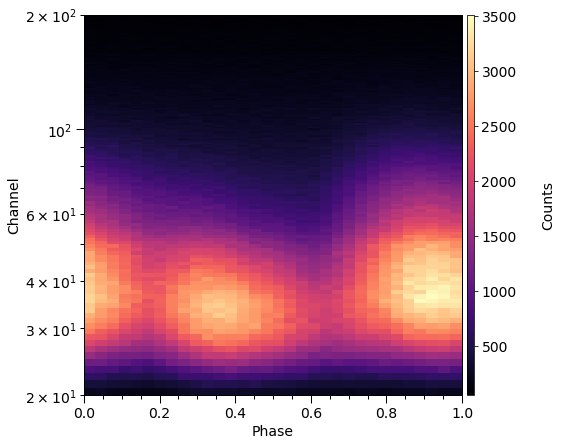

In [9]:
plot_one_pulse(data.counts, data.phases)

### Instrument

We require a model instrument object to transform incident specific flux signals into a form which enters directly in the sampling distribution of the data.

In [10]:
class CustomInstrument(xpsi.Instrument):
    """ A model of the NICER telescope response. """
    
    def __call__(self, signal, *args):
        """ Overwrite base just to show it is possible.
        
        We loaded only a submatrix of the total instrument response
        matrix into memory, so here we can simplify the method in the
        base class.
        
        """
        matrix = self.construct_matrix()

        self._folded_signal = np.dot(matrix, signal)

        return self._folded_signal

    @classmethod
    def from_response_files(cls, ARF, RMF, channel_edges, max_input, min_input=0):
        """ Constructor which converts response files into :class:`numpy.ndarray`s.
        :param str ARF: Path to ARF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str RMF: Path to RMF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str channel_edges: Path to edges which is compatible with
                                  :func:`numpy.loadtxt`.
        
        """

        if min_input != 0:
            min_input = int(min_input)

        max_input = int(max_input)

        try:
            ARF = np.loadtxt(ARF, dtype=np.double, skiprows=3)
            RMF = np.loadtxt(RMF, dtype=np.double)
            if channel_edges:
                channel_edges = np.loadtxt(channel_edges, dtype=np.double, skiprows=3)[:,1:]
        except:
            print('A file could not be loaded.')
            raise
            
        matrix = np.ascontiguousarray(RMF[min_input:max_input,20:201].T, dtype=np.double)

        edges = np.zeros(ARF[min_input:max_input,3].shape[0]+1, dtype=np.double)

        edges[0] = ARF[min_input,1]; edges[1:] = ARF[min_input:max_input,2]

        for i in range(matrix.shape[0]):
            matrix[i,:] *= ARF[min_input:max_input,3]

        channels = np.arange(20, 201)

        return cls(matrix, edges, channels, channel_edges[20:202,-2])

Let's construct an instance.

In [11]:
NICER = CustomInstrument.from_response_files(ARF = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_arf.txt',
                                             RMF = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_rmf_matrix.txt',
                                             max_input = 500,
                                             min_input = 0,
                                             channel_edges = '../../examples/examples_modeling_tutorial/model_data/nicer_v1.01_rmf_energymap.txt')

Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


The NICER ``v1.01`` response matrix:

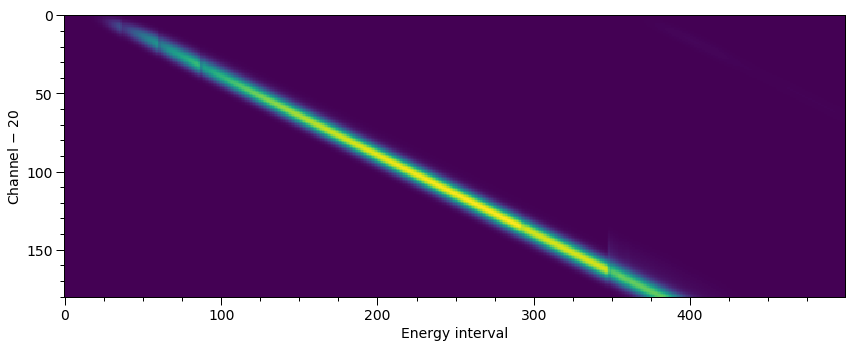

In [12]:
fig = plt.figure(figsize = (14,7))

ax = fig.add_subplot(111)
veneer((25, 100), (10, 50), ax)

_ = ax.imshow(NICER.matrix,
              cmap = cm.viridis,
              rasterized = True)

ax.set_ylabel('Channel $-\;20$')
_ = ax.set_xlabel('Energy interval')

Summed over channel subset $[20,200]$:

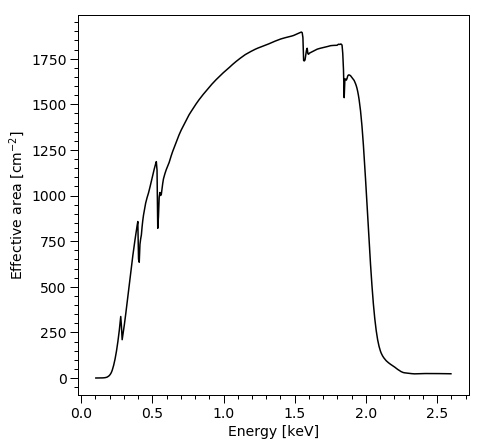

In [13]:
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111)
veneer((0.1, 0.5), (50,250), ax)

ax.plot((NICER.energy_edges[:-1] + NICER.energy_edges[1:])/2.0, np.sum(NICER.matrix, axis=0), 'k-')

ax.set_ylabel('Effective area [cm$^{-2}$]')
_ = ax.set_xlabel('Energy [keV]')

### Signal

We can now combine the dataset and model instrument into a [Signal](signal.rst#xpsi.Signal.Signal) object. The source code for this class has methods and attributes which simplify communication between the aforementioned model objects and another object representing our model star (created below). The surface radiation field of the model star is integrated over based on energies relayed from a
[Signal](signal.rst#xpsi.Signal.Signal) object based on the properties of the instrument and the dataset (which are tightly coupled).

We are forced to inherit from [Signal](signal.rst#xpsi.Signal.Signal) and write a method that evaluates the logarithm of the likelihood conditional on a parametrised sampling distribution for the data. There is much freedom in constructing this sampling distribution, so the design strategy for X-PSI was to leave this part of the modelling process entirely to a user, guided by a number of examples. The only condition for applicability is that the sampling distribution of the data (or of each subset) can be written in terms of a set of *single* count-rate pulses.

In [14]:
from xpsi.likelihoods.default_background_marginalisation import eval_marginal_likelihood
from xpsi.likelihoods.default_background_marginalisation import precomputation

class CustomSignal(xpsi.Signal):
    """
    
    A custom calculation of the logarithm of the likelihood.
    We extend the :class:`~xpsi.Signal.Signal` class to make it callable.
    We overwrite the body of the __call__ method. The docstring for the
    abstract method is copied.
    
    """

    def __init__(self, workspace_intervals = 1000, epsabs = 0, epsrel = 1.0e-8,
                 epsilon = 1.0e-3, sigmas = 10.0, support = None, **kwargs):
        """ Perform precomputation.
        
        :params ndarray[m,2] support:
            Prior support bounds for background count rate variables in the
            :math:`m` instrument channels, where the lower bounds must be zero
            or positive, and the upper bounds must be positive and greater than
            the lower bound. Alternatively, setting the an upper bounds as
            negative means the prior support is unbounded and the flat prior
            density functions per channel are improper. If ``None``, the lower-
            bound of the support for each channel is zero but the prior is
            unbounded.
        
        """

        super(CustomSignal, self).__init__(**kwargs)

        try:
            self._precomp = precomputation(self._data.counts.astype(np.int32))
        except AttributeError:
            print('Warning: No data... can synthesise data but cannot evaluate a '
                  'likelihood function.')
        else:
            self._workspace_intervals = workspace_intervals
            self._epsabs = epsabs
            self._epsrel = epsrel
            self._epsilon = epsilon
            self._sigmas = sigmas
            
            if support is not None:
                self._support = support
            else:
                self._support = -1.0 * np.ones((self._data.counts.shape[0],2))
                self._support[:,0] = 0.0

    def __call__(self, *args, **kwargs):
        self.loglikelihood, self.expected_counts, self.background_signal, self.background_given_support = \
                eval_marginal_likelihood(self._data.exposure_time,
                                          self._data.phases,
                                          self._data.counts,
                                          self._signals,
                                          self._phases,
                                          self._shifts,
                                          self._precomp,
                                          self._support,
                                          self._workspace_intervals,
                                          self._epsabs,
                                          self._epsrel,
                                          self._epsilon,
                                          self._sigmas,
                                          kwargs.get('llzero'),
                                          allow_negative=(False, False))

In the first part of this notebook we define a *marginal* likelihood function. That is, instead of invoking the true background model that in this case is known to us, we invoke a default treatment whereby we marginalise over a set of channel-by-channel background count-rate parameters instead.

We wrote our ``__call__`` method as a wrapper for a extension module to improve speed.  The source code for the simpler case of parameter estimation when the background model is known (see path ``xpsi/examples/true_background``). In general, if you wish to change the model for likelihood evaluation given expected signals, you can archive the Cython extensions in, e.g., the ``xpsi/likelihoods`` directory, and compile these when X-PSI is compiled and installed (by editing the ``setup.py`` script). Alternatively, you can compile your extension elsewhere and call those compiled binaries from your custom class derived from ``Signal``.

Let's construct and instantiate a ``Signal`` object. We must accept phase shift parameters, which are a *fast* nuisance parameter; this detailed in the docstring of ``Signal``. The bounds of the background parameter have already been specified above.

In [15]:
signal = CustomSignal(data = data,
                        instrument = NICER,
                        background = None,
                        interstellar = None,
                        workspace_intervals = 1000,
                        cache = True,
                        epsrel = 1.0e-8,
                        epsilon = 1.0e-3,
                        sigmas = 10.0,
                        support = None)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


### Constructing a star

We now need to build our star. The basic units for building a star are:

* the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class;
* the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class;
* the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class;
* the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) class;
* and four low-level user-modifiable routines for evaluation of a parametrised specific intensity model.

For this demonstration we will assume that the surface radiation field *elsewhere* (other than the hot regions) can be ignored in the soft X-ray regime our model instrument is sensitive to. For more advanced modelling, we can simply write custom *derived* classes, and instantiate those derived classes to construct objects for our model. In particular, a common pattern will be to subclass the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class. Let's start with the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class.

#### The ambient spacetime

In [16]:
xpsi.Spacetime#? # uncomment to query

xpsi.Spacetime.Spacetime

We can instanciate the `spacetime` by defining all parameters with a given value.  In this case, all parameters will be fixed because the `bounds` are not specified (empty dictionary). **Note that all parameters must be defined at least once in `bounds` or `values`.** 

In [17]:
values = dict(distance =0.150,          # (Earth) distance
                mass = 1.5,             # mass
                radius = 12.0,          # equatorial radius
                cos_inclination = 0.5,  # (Earth) inclination to rotation axis
                frequency = 300. )      # spin frequency

spacetime = xpsi.Spacetime(bounds={}, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with fixed value 1.500e+00.
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with fixed value 1.200e+01.
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with fixed value 1.500e-01.
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with fixed value 5.000e-01.
    > Cosine of Earth inclination to rotation axis.


Alternatively we can specify bounds manually for the free parameters. Using `(None, None)` will set the default bounds. The fixed parameters are defined in the `values` dictionary.  If both the bounds and a value are defined for a parameters, the value will not be fixed but instead will be set as an initial value.

In [18]:
bounds = dict(distance = (None, None),                   # Default bounds for (Earth) distance
                mass = (None, None),                     # Default bounds for mass 
                radius = (None, None),                   # Default bounds for equatorial radius
                cos_inclination = (None, None))          # Default bounds for (Earth) inclination to rotation axis

values = dict(frequency=300.0,                           # Fixed spin frequency
              mass=1.4)                                  # mass with initial value

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e-03, 3.000e+00] and initial value 1.400e+00.
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+00, 2.000e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-02, 3.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [-1.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


To display the free parameters:

In [19]:
for p in spacetime:
    print(p)

Gravitational mass [solar masses].
Coordinate equatorial radius [km].
Earth distance [kpc].
Cosine of Earth inclination to rotation axis.


For the following example in this tutorial, we will specify the bounds of all parameters.

In [20]:
bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass with default bounds
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))            # (Earth) inclination to rotation axis

values = dict(frequency=300.0 )                          # Fixed spin frequency

spacetime = xpsi.Spacetime(bounds=bounds, values=values)

Creating parameter:
    > Named "frequency" with fixed value 3.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


#### The photosphere and its constituent regions

It is not necessary for us to write a custom derived class for the photosphere object, so we will simply instantiate a [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) object. However, we first need an instance of [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) to instantiate the photosphere, and we need to implement a low-level parametrised model for the specific intensity emergent from the photosphere in a local comoving frame.

The neutron star atmosphere is assumed to be geometrically thin. In the applications thus far, the surface local-comoving-frame radiation field as being described by a single *free* parameter: the effective temperature. The radiation field is also dependent on the local effective gravitational acceleration, however this is a *derived* parameter in the model. The parametrised radiation field as a function of energy and angle subtended to the normal to the (plane-parallel) atmosphere in a local comoving frame is provided as numerical model data for multi-dimensional interpolation.

In X-PSI, integration over the surface radiation field is performed via calls to low-level C routines. To reduce likelihood evaluation times, the atmosphere interpolator is written in C, and calls to that interpolator are from C routine. In other words, in X-PSI, **we do not use Python callback functions for evaluation of specific intensities, but C functions which are compiled when the** X-PSI **package is built**. Unfortunately this means that to change the parametrised surface radiation field you need to get your hands a little dirty; on the bright side, the body of these functions can be implemented almost completely in the Cython language, so syntactically there is some similarity to Python because the language syntax is somewhat of a hybrid/superset. Beware, however, that the body of these functions must not contain calls to the Python API, and only to external C libraries if required: the code must evaluate to pure C, and not require the Python/C API. Note that the Python global interpreter lock is deactivated during integration to enable OpenMP multi-threading in some applications of the integrator; thus the code needs to be thread safe and ``nogil`` (not require the global interpreter lock, although a context manager could *in principle* be used to reacquire the lock within the integrator). Also note that if external C libraries are required, that you include a Cython .pxd (header) file in the package which ``extern``s the required library components; the library also needs to be included and linked in ``setup.py`` at package build-time.

*You are encouraged to ask the author of X-PSI for assistance in implementing your low-level surface radiation field model if you are uncertain. If you have ideas for making this model specification more user-friendly, without, crucially, increasing signal integration time, please contact the author or submit a pull request.*

The following is the contents of the ``hot.pxd`` file which the X-PSI integrators use as the header file for including other C functions in the package.

```cython
from preload cimport _preloaded

cdef double eval_hot(size_t THREAD,
                     double E,
                     double mu,
                     const double *const VEC,
                     void *const data) nogil

cdef double eval_hot_norm() nogil

cdef void* init_hot(size_t numThreads, const _preloaded *const preloaded) nogil

cdef int free_hot(size_t numThreads, void *const data) nogil
```

**You are free to modify these functions in the associated** ``hot.pyx`` **implementation file, and you have almost complete control over the function bodies, but not the signatures.** By default the package includes an isotropic blackbody model:

```cython
#cython: cdivision=True
#cython: boundscheck=False
#cython: nonecheck=False
#cython: wraparound=False

from libc.math cimport exp, pow

from xpsi.global_imports import _keV, _k_B

cdef int SUCCESS = 0

cdef double erg = 1.0e-7
cdef double Planck_dist_const = 5.040366110812353e22

cdef double k_B = _k_B
cdef double keV = _keV
cdef double k_B_over_keV = k_B / keV

#----------------------------------------------------------------------->>>
# >>> User modifiable functions.
# >>> Note that the user is entirely free to wrap thread-safe and
# ... non-parallel external C routines from an external library.
# >>> Thus the bodies of the following need not be written explicitly in
# ... the Cython language.
#----------------------------------------------------------------------->>>
cdef void* init_hot(size_t numThreads, const _preloaded *const preloaded) nogil:
    # This function must match the free management routine free_hot()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.

    # Return NULL if dynamic memory is not required for the model.
    return NULL

cdef int free_hot(size_t numThreads, void *const data) nogil:
    # This function must match the initialisation routine init_hot()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.
    # The void pointer must be appropriately cast before memory is freed --
    # only the user can know this at compile time.
    # Just use free(<void*> data) iff no memory was dynamically
    # allocated in the function:
    #   init_local_hot()
    # because data is expected to be NULL in this case

    #printf("\nNo data to be freed.")

    return SUCCESS

cdef double eval_hot(size_t THREAD,
                     double E,
                     double mu,
                     const double *const VEC,
                     void *const data) nogil:
    # Arguments:
    # E = photon energy in keV
    # mu = cosine of ray zenith angle (i.e., angle to surface normal)
    # VEC = variables such as temperature, effective gravity, ...
    # data = numerical model data required for intensity evaluation

    cdef double temp = k_B_over_keV * pow(10.0, VEC[0])

    return E * E * E / ( exp(E / temp) - 1.0 )

cdef double eval_hot_norm() nogil:
    # Source radiation field normalisation which is independent of the
    # parameters of the parametrised model -- i.e. cell properties, energy,
    # and angle.
    # Writing the normalisation here reduces the number of operations required
    # during integration.
    # The units of the specific intensity need to be J/cm^2/s/keV/steradian.

    return erg * Planck_dist_const
```

In most use-cases we need to modify these functions to enable handling of the numerical atmosphere data. An extension for such a case may be found as an [example](surface_radiation_field.rst#a-numerical-atmosphere), which contains the extension used by [Riley et al. (2019)](applications.rst#riley-et-al-2019-apjl-887-l21) to implement a numerical atmosphere generated by the NSX atmosphere code ([Ho, W.C.G & Lai, D. 2001](https://ui.adsabs.harvard.edu/abs/2001MNRAS.327.1081H/abstract); [Ho, W.C.G & Heinke, C.O. 2009](https://ui.adsabs.harvard.edu/link_gateway/2009Natur.462...71H/doi:10.1038/nature08525)), courtesy of W.C.G. Ho for NICER modeling efforts. A fully-ionized hydrogen atmosphere (Ho & Lai 2001) was used in [Riley et al. (2019)](applications.rst#riley-et-al-2019-apjl-887-l21); also see Bogdanov et al. (2020).

Changing the model for the parametrised surface emission requires re-compiling X-PSI using the appropriate flags for the hot regions and/or for the rest of the surface (see [Installation](install.rst)). Alternatively, you can compile your extension elsewhere and link it when X-PSI is installed (by editing the ``setup.py`` script), `cimporting` or `extern`ing from the appropriate `.pxd` header file(s), and calling those precompiled binaries from the functions declared in the ``xpsi/surface_radiation_field/hot.pxd`` header.

We now instantiate hot region objects. We can find the required and optional parameter names in the class docstring:

In [21]:
xpsi.HotRegion#? # uncomment to query

xpsi.HotRegion.HotRegion

The names can also be found as class attributes as follows:

In [22]:
xpsi.HotRegion.required_names

['super_colatitude',
 'super_radius',
 'phase_shift',
 'super_temperature (if no custom specification)']

The condition *if no custom specification* means that this name is required if we do not supply custom parameters for the radiation field in the superseding member of the hot region. If we supply custom parameters, we also need to subclass ``xpsi.HotRegion`` and overwrite the ``__compute_cellParamVecs`` method to handle our parameters.

In [23]:
xpsi.HotRegion.optional_names

['omit_colatitude',
 'omit_radius',
 'omit_azimuth',
 'cede_colatitude',
 'cede_radius',
 'cede_azimuth',
 'cede_temperature']

For the purpose of illustration, we *tie* the temperatures of the hot regions together: *this is where the model deviates from the examples directory as alluded to in the preamble of this tutorial*. There is more than one way to achieve this, but we will use the most powerful approach.

In [24]:
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (-0.25, 0.75),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            prefix='p') # unique prefix needed because >1 instance

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-2.500e-01, 7.500e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.000e+00].
    > log10(superseding region effective temperature [K]).


Note that since the atmospheric local-comoving-frame effective temperature is uniform everywhere within the hot region boundaries, we can use the default value of the ``symmetry`` keyword, ``True``. All other arguments determine the numerical resolution, and have defaults which have been (somewhat arbitrarily) chosen to be result in a likelihood evaluation time of $\mathcal{O}(1)$ s.

Let's take a look at the ``xpsi.Derive`` docstring for guidance:

In [25]:
xpsi.Derive#? # uncomment to query

xpsi.Parameter.Derive

In [26]:
class derive(xpsi.Derive):
    def __init__(self):
        """
        We can pass a reference to the primary here instead
        and store it as an attribute if there is risk of
        the global variable changing.
        
        This callable can for this simple case also be
        achieved merely with a function instead of a magic
        method associated with a class.
        """
        pass

    def __call__(self, boundto, caller = None):
        # one way to get the required reference
        global primary # unnecessary, but for clarity
        return primary['super_temperature'] - 0.2
    
bounds['super_temperature'] = None # declare fixed/derived variable

secondary = xpsi.HotRegion(bounds=bounds, # can otherwise use same bounds
                              values={'super_temperature': derive()}, # create a callable value
                              symmetry=True,
                              omit=False,
                              cede=False,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              is_antiphased=True,
                              prefix='s') # unique prefix needed because >1 instance

Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-2.500e-01, 7.500e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" that is derived from ulterior variables.
    > log10(superseding region effective temperature [K]).


The description *derived from ulterior variables* means that when we lookup the value, it is calculated dynamically from the values of other (ulterior) model parameters. We clearly expect the temperature of the secondary hot region to behave in this way. A few other varibles do to because of keyword arguments passed upon instantiation of the hot regions. For example, the colatitude of the *zero-radii* omission and ceding regions (``omit=False`` and ``cede=False``) are equivalent to the colatitude of the centre of the superseding region. The azimuths are *relative* to the superseding region, and are thus listed as being *fixed* at zero azimuthal separation. If one of ``omit`` or ``cede`` was ``True``, and ``concentric=True``, a similar setup is performed, but with the radius of ``omit`` or ``cede`` being free, fixed (at finite value, but zero achieves the same as ``False`` for both ``omit`` and ``cede`` keyword arguments), or derived.

We now need to encapsulate the hot region instances in a container with properties expected by the ``Photosphere`` class.

In [27]:
from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Let's check out the hot regions:

In [28]:
hot.objects[0] # 'p'

Free parameters
---------------
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).

Derived/fixed parameters
------------------------
p__cede_colatitude: The colatitude of the centre of the ceding region [radians].
p__cede_radius: The angular radius of the (circular) ceding region [radians].
p__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
p__omit_colatitude: The colatitude of the centre of the omission region [radians].
p__omit_radius: The angular radius of the (circular) omission region [radians].
p__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

In [29]:
hot.objects[1] # 's'

Free parameters
---------------
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].

Derived/fixed parameters
------------------------
s__super_temperature: log10(superseding region effective temperature [K]).
s__cede_colatitude: The colatitude of the centre of the ceding region [radians].
s__cede_radius: The angular radius of the (circular) ceding region [radians].
s__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
s__omit_colatitude: The colatitude of the centre of the omission region [radians].
s__omit_radius: The angular radius of the (circular) omission region [radians].
s__omit_azimuth: The azimuth of the centre of the omission region relative to the
centre of the superseding region [radians].

A list of names, with the prefix, can also be accessed as follows:

In [30]:
h = hot.objects[0]
h.names

['p__phase_shift',
 'p__super_colatitude',
 'p__super_radius',
 'p__super_temperature',
 'p__cede_colatitude',
 'p__cede_radius',
 'p__cede_azimuth',
 'p__omit_colatitude',
 'p__omit_radius',
 'p__omit_azimuth']

In [31]:
h.prefix

'p'

In [32]:
h.get_param('phase_shift')

The phase of the hot region, a periodic parameter [cycles]

Let's set a value for the temperature of the primary hot region:

In [33]:
hot['p__super_temperature'] = 6.0 # equivalent to ``primary['super_temperature'] = 6.0``

Now let's lookup the temperature of the secondary:

In [34]:
secondary['super_temperature']

5.8

No value was set explicitly for this secondary temperature: it is looked up dynamically from that of the primary hot region.

Note that the following access will *not* work:

In [35]:
# hot['s__super_temperature']

The reason for this is because the temperature of the secondary hot region is a *fixed/derived* variable. Only *free* model parameters are merged into larger spaces. A fixed/derived variable needs to be accessed via the subspace that directly encapsulates a reference to it.

We can now instantitate the photosphere:

In [36]:
class CustomPhotosphere(xpsi.Photosphere):
    """ Implement method for imaging."""
    
    @property
    def global_variables(self):
    
        return np.array([self['p__super_colatitude'],
                          self['p__phase_shift'] * _2pi,
                          self['p__super_radius'],
                          self['p__super_temperature'],
                          self['s__super_colatitude'],
                          (self['s__phase_shift'] + 0.5) * _2pi,
                          self['s__super_radius'],
                          self.hot.objects[1]['s__super_temperature']])

In [37]:
photosphere = CustomPhotosphere(hot = hot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))

Creating parameter:
    > Named "mode_frequency" with fixed value 3.000e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


In [38]:
photosphere['mode_frequency'] == spacetime['frequency']

True

Note that generally the ``Photosphere`` instance must have a prefix that matches a prefix given to a ``Signal`` instance to ensure the user achieves what they intend for likelihood evaluation; when the model defines multiple data subsets and thus multiple [Signal](signal.rst#xpsi.Signal.Signal) instances, tagging the objects in this manner is a safety guard (in particular against inadvertently wasting compute resources sampling a distribution conditional on an unintended model). If there is one ``Photosphere`` and one ``Signal`` object, the prefixes can simply be none because there is no potential ambiguity.

We do not model the surface radiation field *elsewhere*, and we thus leave the ``elsewhere`` keyword as ``None`` (the default). *Elsewhere* means on the surface, exterior to radiating hot regions that are typically expected to span a smaller angular extent; in the current version, the radiation from *elsewhere*, if explicitly computed is assumed to be time-invariant supposing the hot regions were not present. To account for radiation from *elsewhere*, a time-invariant signal is first computed, meaning an axisymmetric surface local-comoving-frame radiation field is assumed. The time-dependent signals from the hot regions are then computed, and modified by subtracting the specific intensity that would otherwise be generated by the surface local-comoving-frame radiation field from *elsewhere* (i.e., in place of the hot regions).  

#### Star

We can now combine the ambient spacetime, ``spacetime``, and the embedded photosphere, ``photosphere``, into a model star represented by an instance of [Star](star.rst#xpsi.Star.Star). We do not need to extend this class, so we can simply construct and instantiate a star as follows:

In [39]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

Let's check out the star object, which merged parameter subspaces associated with objects lower in the hierarchy:

In [40]:
star

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].

Note that only the free parameters are merged into a subspace higher in the object hierarchy. The reason for this is
that there is not a clear and common pattern (at present) for accessing fixed/derived variables outside of the primary subspace to which they belong. If you try hard enough, of course, you can still get at them.

### A callable likelihood object

Given the objects constructed above and the relevant pre-compiled low-level code, we can now construct and instantiate a *callable* likelihood object. We do not need extend (via inheritance) the [Likelihood](likelihood.rst#xpsi.Likelihood.Likelihood) class found the source code: this class simply combines all of the model objects defined above, performs some automatic operations given the properties of the those objects, and facilitates communication of those objects when it recieves a call to evaluate the likelihood.

In [41]:
likelihood = xpsi.Likelihood(star = star, signals = signal,
                             num_energies=128,
                             threads=1,
                             externally_updated=False)

Let's retrieve the total number of free model parameters merged into the full parameter space:

In [42]:
likelihood

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].

In [43]:
len(likelihood)

11

**Note that if you want to modify the definition of the model parameter space you should restart the process of constructing a** ``likelihood`` **object, instead of manipulating existing objects, for ultimate safety.** (You can also restart the kernel although if this is required it is a bug.)

Let's call the ``likelihood`` object with the true model parameter values that we injected to generate the synthetic data rendered above, omitting background parameters. Note that you can switch the phase interpolant invoked from GSL by:

In [44]:
xpsi.set_phase_interpolant('Akima')

Pre-`v0.6`, the interpolant choice was `'Steffen'`, but the default is now `'Akima'`, and this notebook was executed with this default.

In [45]:
p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2]

likelihood.clear_cache()
t = time.time()
# source code changes since model was applied, so let's be a
# bit lenient when checking the likelihood function
likelihood.check(None, [-26713.6136777], 1.0e-6,
                 physical_points=[p])
 
print('time = %.3f s' % (time.time() - t))

# > xpsi.set_phase_interpolant('Akima')
# Checking likelihood and prior evaluation before commencing sampling...
# Cannot import ``allclose`` function from NumPy.
# Using fallback implementation...
# Checking closeness of likelihood arrays:
# -2.67136012e+04 | -2.67136137e+04 .....
# Closeness evaluated.
# Log-likelihood value checks passed on root process.
# Checks passed.
# time = 0.571 s

# > xpsi.set_phase_interpolant('Steffen')
# Checking likelihood and prior evaluation before commencing sampling...
# Cannot import ``allclose`` function from NumPy.
# Using fallback implementation...
# Checking closeness of likelihood arrays:
# -2.67136140e+04 | -2.67136137e+04 .....
# Closeness evaluated.
# Log-likelihood value checks passed on root process.
# Checks passed.
# time = 0.581 s

# > xpsi.set_phase_interpolant('Cubic')
# Checking likelihood and prior evaluation before commencing sampling...
# Cannot import ``allclose`` function from NumPy.
# Using fallback implementation...
# Checking closeness of likelihood arrays:
# -2.67135656e+04 | -2.67136137e+04 .....
# Closeness evaluated.
# Log-likelihood value checks passed on root process.
# Checks passed. (increasing the tolerance to 1e-5)
# time = 0.720 s (consistently slower)

Checking likelihood and prior evaluation before commencing sampling...
Cannot import ``allclose`` function from NumPy.
Using fallback implementation...
Checking closeness of likelihood arrays:
-2.67136014e+04 | -2.67136137e+04 .....
Closeness evaluated.
Log-likelihood value checks passed on root process.
Checks passed.
time = 0.786 s


If the secondary temperature was free, we would extend the vector ``p`` by one element, passing the injected value of ``6.0``:

In [46]:
secondary['super_temperature']

6.0

External sampling software will interact with a ``likelihood`` object in this way. That is, it will pass some ordered container of parameter values: a vector. However, this vector will be ignored if the ``likelihood`` instance is told it can safely assume all parameters have been updated *externally*, meaning before the call is placed to ``likelihood.__call__()``. This external update will typically happen during *nested sampling* when a call is placed to a ``prior`` object to inverse sample from the joint prior distribution. Our ``prior`` object can interact with our ``likelihood`` object outside of a sampling process, and thus we can encapsulate a reference to the parameter space in the ``prior`` instance and simply update the parameter values using easier handles (via ``__getitem__`` magic) to conclude an inverse sampled procedure.

### Inspecting functionality

Calling the ``likelihood`` object also modified the ``signals`` property of the ``photosphere`` object. Let's plot the ``signals`` by summing the count-rate over output instrument channels. We first define a helper function.

In [47]:
def plot_pulse():
    """ Plot hot region signals before and after telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    
    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')
    
    temp = np.sum(signal.signals[0], axis=0)
    ax.plot(signal.phases[0], temp/np.max(temp), '-', color='k', lw=0.5)
    temp = np.sum(signal.signals[1], axis=0)
    ax.plot(signal.phases[1], temp/np.max(temp), '-', color='r', lw=0.5)
    
    temp = np.sum(photosphere.signal[0][0], axis=0)
    ax.plot(signal.phases[0], temp/np.max(temp), 'o-', color='k', lw=0.5, markersize=2)
    temp = np.sum(photosphere.signal[1][0], axis=0)
    ax.plot(signal.phases[1], temp/np.max(temp), 'o-', color='r', lw=0.5, markersize=2)
    
    veneer((0.05,0.2), (0.05,0.2), ax)

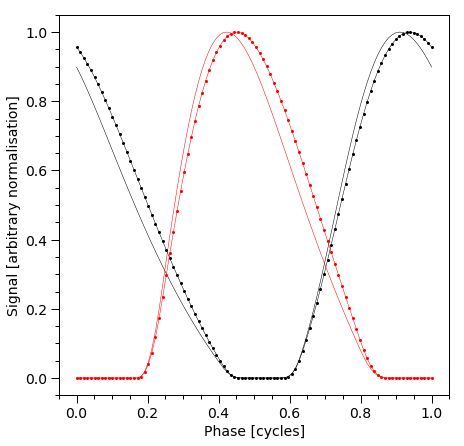

In [48]:
likelihood(p, reinitialise=False)
_ = plot_pulse()

The pulse-profiles with markers are the signals incident on the telescope, before operating on them with the response model. The markers, linearly spaced in phase, denote the phase resolution.

The ``likelihood`` object calls the ``star.update`` method which in-turn calls the ``photosphere.embed`` method. The ``likelihood`` object then calls the ``photosphere.integrate`` method, passing the energies stored as the property ``signal.energies``. We can do this manually if we wish to integrate signals but not calculate likelihoods. Here we sum over incident specific photon flux pulses as an approximation to integrating over energy. Note that we do not change the ``signal.signals`` traced by the solid curves without markers.

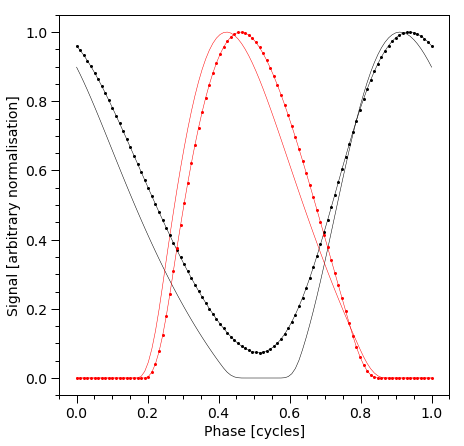

In [49]:
likelihood['cos_inclination'] = math.cos(1.0)

likelihood.externally_updated = True # declare safe to assume updates performed before call
xpsi.ParameterSubspace.__call__(likelihood) # no vector supplied
star.update()
photosphere.integrate(energies=signal.energies, threads=1)

_ = plot_pulse()

Notice the solid pulses without markers are unchanged from the plot a few cells above, and can be used to guide the eye to the effect of a change in Earth inclination.

Below we print crude representations of the cell meshes spanning each hot region. The elements of a mesh cell-area array which are finite are not all identical: at the boundary of a hot region the proper area elements are smaller because of partial coverage by radiating material. The sum of all finite proper areas effectively equals the total proper area within a hot-region boundary.

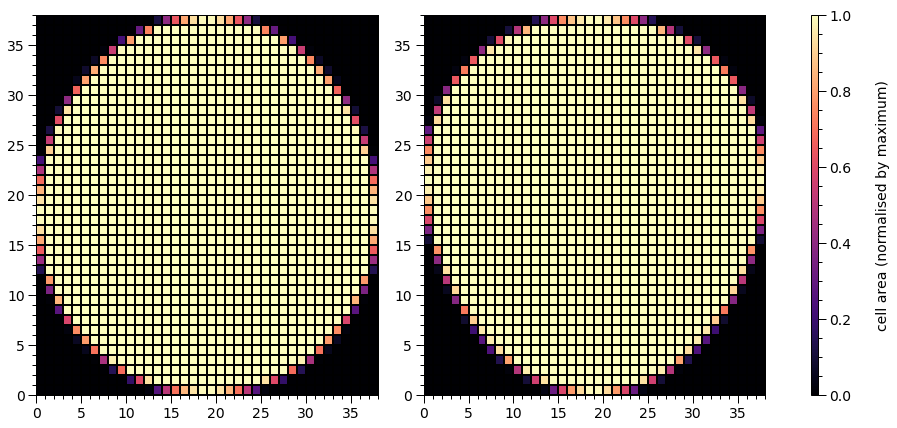

In [50]:
fig = plt.figure(figsize = (14,7))

gs = gridspec.GridSpec(1, 3, width_ratios=[50,50,1], wspace=0.2)
ax = plt.subplot(gs[0])
veneer((1,5), (1, 5), ax)

# primary (lower colatitude) hot region
h = hot.objects[0]
z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
patches = plt.pcolormesh(z,
                         vmin = np.min(z),
                         vmax = np.max(z),
                         cmap = cm.magma,
                         linewidth = 1.0,
                         rasterized = True,
                         edgecolor='black')

ax = plt.subplot(gs[1])
veneer((1,5), (1, 5), ax)

# secondary (higher colatitude) hot region
h = hot.objects[1]
z = h._HotRegion__cellArea[0]/np.max(h._HotRegion__cellArea[0])
_ = plt.pcolormesh(z,
                   vmin = np.min(z),
                   vmax = np.max(z),
                   cmap = cm.magma,
                   linewidth = 1.0,
                   rasterized = True,
                   edgecolor='black')

ax_cb = plt.subplot(gs[2])
cb = plt.colorbar(patches,
                  cax = ax_cb,
                  ticks = MultipleLocator(0.2))

cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
cb.solids.set_edgecolor('face')

veneer((None, None), (0.05, None), ax_cb)
cb.outline.set_linewidth(1.0)

Note that the lowest colatitude row is at zero on the y-axis.

Let's plot a pulse in two dimensions. Also note that we can interpolate the signal in phase as follows.

In [51]:
from xpsi.tools import phase_interpolator

In [52]:
def plot_2D_pulse(z, x, shift, y, ylabel,
                  num_rotations=5.0, res=5000, figsize=(12,6),
                  cm=cm.viridis),
                  ticks=None):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator(new_phases,
                                      x,
                                      z[0], shift[0])
    interpolated += phase_interpolator(new_phases,
                                       x,
                                       z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, num_rotations])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax, ticks=ticks)
    if ticks is not None:
        ax.set_yticklabels(ticks)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

The incident specific flux signal, in units of photons/cm$^{2}$/s/keV as output by the source code, and then normalised to the maximum in specific flux:

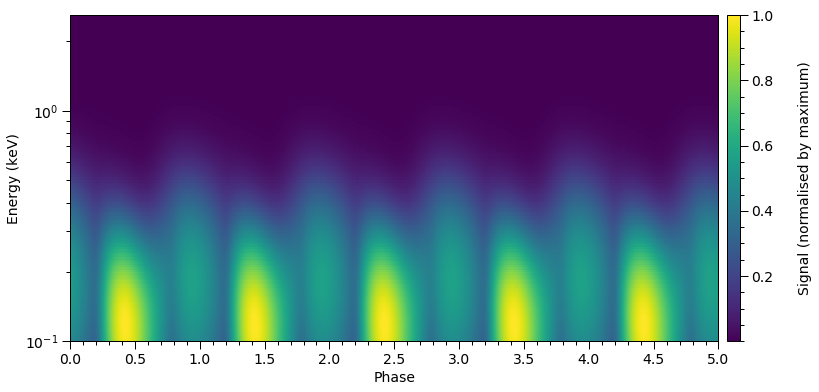

In [53]:
plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[1][0]),
              x=signal.phases[0],
              shift=signal.shifts,
              y=signal.energies,
              ylabel=r'Energy (keV)',
              ticks=[0.1, 0.5,1.0,2.0])

The count rate signal in each channel:

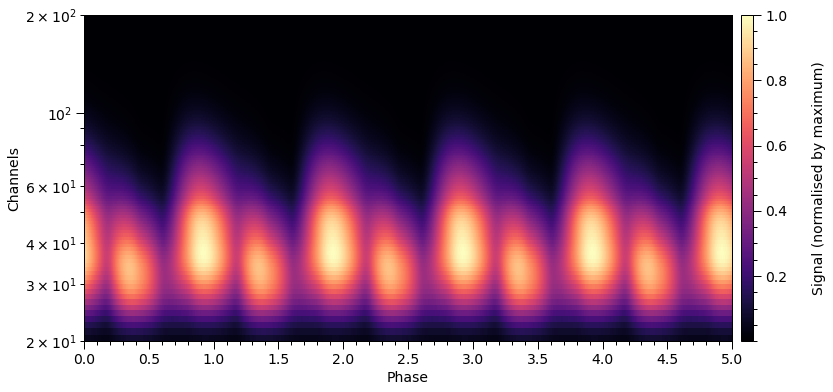

In [54]:
plot_2D_pulse((signal.signals[0], signal.signals[1]),
              x=signal.phases[0],
              shift=signal.shifts,
              y=NICER.channels,
              ylabel=r'Channels',
              cm=cm.magma,
              ticks=[20,50,100,200])

Now we increase the phase resolution, and plot a single rotational pulse:

In [55]:
for obj in hot.objects:
    obj.set_phases(num_leaves = 1024)
# the current relationship between objects requires that we reinitialise
# if we wish to automatically communicate the updated settings between objects
p[3] = math.cos(1.0) # set inclination
_ = likelihood(p, reinitialise = True)

Note that reinitialisation also returned the following to default:

In [56]:
likelihood.externally_updated

False

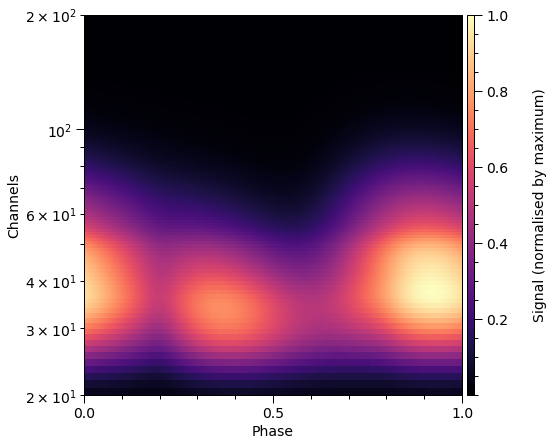

In [57]:
plot_2D_pulse((signal.signals[0], signal.signals[1]),
              x=signal.phases[0],
              shift=signal.shifts,
              y=NICER.channels,
              ylabel=r'Channels',
              num_rotations=1.0,
              cm=cm.magma,
              ticks=[20,50,100,200],
              figsize=(7,7))

Let's iterate over a monotonically increasing set of values of the hot-region angular radius. Note that we use the keyword ``threads`` to directly instruct the low-level routines how many OpenMP threads to spawn to accelerate the computation. Usually the ``likelihood`` object instructs the low-level routines how many threads to spawn, based on it's ``thread`` property:

In [58]:
likelihood.threads

1

Given that we are not currently using the ``likelihood`` object as a callback function passed to posterior sampling software (which parallelises efficiently using MPI), we can safely spawn additional OpenMP threads for signal integration; if likelihood evaluations are parallelised in an MPI environment on the other hand, one risks *losing* efficiency by spawning OpenMP threads for likelihood evaluation.

For objects that derive from ``ParameterSubspace`` we can get the current parameter vector in several ways:

In [59]:
star()

[1.4,
 12.5,
 0.2,
 0.5403023058681398,
 0.0,
 1.0,
 0.075,
 6.2,
 0.025,
 2.141592653589793,
 0.2]

In [60]:
star() == star.vector # possible shortcut to save some characters

True

The ``Likelihood`` subclass overrides the ``__call__`` dunder, however, so we have to access it in the following ways:

In [61]:
super(xpsi.Likelihood, likelihood).__call__() == likelihood.vector

True

Note that we did not define any other parameters other than those associated with the ``star``, and thus:

In [62]:
len(likelihood) == len(star)

True

Finally, let's play with some geometric parameters:

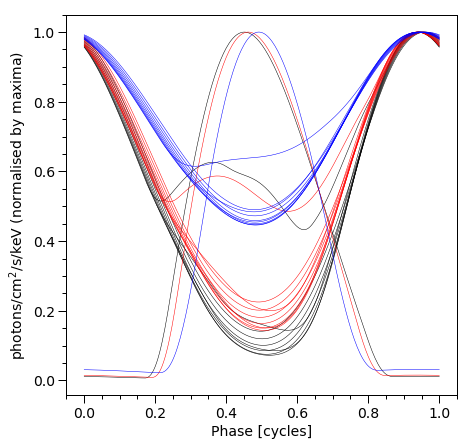

In [63]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_ylabel('photons/cm$^2$/s/keV (normalised by maxima)')
ax.set_xlabel('Phase [cycles]')

for obj in hot.objects:
    obj.set_phases(num_leaves = 256)

# let's play with the angular radius of the primary hot region
angular_radii = np.linspace(0.01, 1.0, 10)

likelihood.externally_updated = True

likelihood['cos_inclination'] = math.cos(1.25)

for angular_radius in angular_radii:
    likelihood['p__super_radius'] = angular_radius # play time
    star.update()
    photosphere.integrate(energies=signal.energies, threads=3)
    temp = np.sum(photosphere.signal[0][0] + photosphere.signal[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'k-', lw=0.5)

likelihood['cos_inclination'] = math.cos(1.0)
    
for angular_radius in angular_radii:
    likelihood['p__super_radius'] = angular_radius
    star.update()
    photosphere.integrate(energies=signal.energies, threads=3)
    temp = np.sum(photosphere.signal[0][0] + photosphere.signal[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'r-', lw=0.5)

likelihood['cos_inclination'] = math.cos(0.5)

for angular_radius in angular_radii:
    likelihood['p__super_radius'] = angular_radius
    star.update()
    photosphere.integrate(energies=signal.energies, threads=3)
    temp = np.sum(photosphere.signal[0][0] + photosphere.signal[1][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles[0], temp/np.max(temp), 'b-', lw=0.5)
    
veneer((0.05,0.2), (0.05,0.2), ax)

## Prior

Let us now construct a callable object representing a joint prior density distribution on the space $\mathbb{R}^{d}$. We need to extend the base class to implement our distribution, which with respect to some parameters is separable, but for others it is *uniform* on a joint space, and compactly supported according to non-trivial constraint equations.

As an example gravitational mass and equatorial radius: a joint constraint is imposed to assign zero density to stars which are *too* compact: the polar radius, in units of the gravitational radius, of the rotationally deformed stellar 2-surface is too small.

### Custom subclass

In [64]:
from scipy.stats import truncnorm

In [65]:
class CustomPrior(xpsi.Prior):
    """ A custom (joint) prior distribution.
    
    Source: Fictitious
    Model variant: ST-U
        Two single-temperature, simply-connected circular hot regions with
        unshared parameters.
    
    """
    
    __derived_names__ = ['compactness', 'phase_separation',]
    __draws_from_support__ = 3
    
    def __init__(self):
        """ Nothing to be done.
        
        A direct reference to the spacetime object could be put here
        for use in __call__:
        
        .. code-block::
        
            self.spacetime = ref
            
        Instead we get a reference to the spacetime object through the
        a reference to a likelihood object which encapsulates a
        reference to the spacetime object.
        
        """
        super(CustomPrior, self).__init__() # not strictly required if no hyperparameters
    
    def __call__(self, p = None):
        """ Evaluate distribution at ``p``.
        
        :param list p: Model parameter values.
        
        :returns: Logarithm of the distribution evaluated at ``p``.
        
        """
        temp = super(CustomPrior, self).__call__(p)
        if not np.isfinite(temp):
            return temp
        
        # based on contemporary EOS theory
        if not self.parameters['radius'] <= 16.0:
            return -np.inf
        
        ref = self.parameters.star.spacetime # shortcut

        # limit polar radius to try to exclude deflections >= \pi radians
        # due to oblateness this does not quite eliminate all configurations
        # with deflections >= \pi radians
        R_p = 1.0 + ref.epsilon * (-0.788 + 1.030 * ref.zeta)
        if R_p < 1.76 / ref.R_r_s:
            return -np.inf
        
        # polar radius at photon sphere for ~static star (static ambient spacetime)
        #if R_p < 1.5 / ref.R_r_s:
        #    return -np.inf

        mu = math.sqrt(-1.0 / (3.0 * ref.epsilon * (-0.788 + 1.030 * ref.zeta)))

        # 2-surface cross-section have a single maximum in |z|
        # i.e., an elliptical surface; minor effect on support, if any,
        # for high spin frequenies
        if mu < 1.0:
            return -np.inf
        
        ref = self.parameters # redefine shortcut

        # enforce order in hot region colatitude
        if ref['p__super_colatitude'] > ref['s__super_colatitude']:
            return -np.inf

        phi = (ref['p__phase_shift'] - 0.5 - ref['s__phase_shift']) * _2pi

        ang_sep = xpsi.HotRegion.psi(ref['s__super_colatitude'],
                                     phi,
                                     ref['p__super_colatitude'])

        # hot regions cannot overlap
        if ang_sep < ref['p__super_radius'] + ref['s__super_radius']:
            return -np.inf

        return 0.0

    def inverse_sample(self, hypercube=None):
        """ Draw sample uniformly from the distribution via inverse sampling. """
        
        to_cache = self.parameters.vector
        
        if hypercube is None:
            hypercube = np.random.rand(len(self))
        
        # the base method is useful, so to avoid writing that code again:
        _ = super(CustomPrior, self).inverse_sample(hypercube)
        
        ref = self.parameters # shortcut
        
        idx = ref.index('distance')
        ref['distance'] = truncnorm.ppf(hypercube[idx], -2.0, 7.0, loc=0.3, scale=0.1)
        
        # flat priors in cosine of hot region centre colatitudes (isotropy)
        # support modified by no-overlap rejection condition
        idx = ref.index('p__super_colatitude')
        a, b = ref.get_param('p__super_colatitude').bounds
        a = math.cos(a); b = math.cos(b)
        ref['p__super_colatitude'] = math.acos(b + (a - b) * hypercube[idx])

        idx = ref.index('s__super_colatitude')
        a, b = ref.get_param('s__super_colatitude').bounds
        a = math.cos(a); b = math.cos(b)
        ref['s__super_colatitude'] = math.acos(b + (a - b) * hypercube[idx])
        
        # restore proper cache
        for parameter, cache in zip(ref, to_cache):
            parameter.cached = cache

        # it is important that we return the desired vector because it is
        # automatically written to disk by MultiNest and only by MultiNest
        return self.parameters.vector  

    def transform(self, p, **kwargs):
        """ A transformation for post-processing. """

        p = list(p) # copy
        
        # used ordered names and values
        ref = dict(zip(self.parameters.names, p))
        
        # compactness ratio M/R_eq
        p += [gravradius(ref['mass']) / ref['radius']]
        
        # phase separation between hot regions
        # first some temporary variables:
        if ref['p__phase_shift'] < 0.0:
            temp_p = ref['p__phase_shift'] + 1.0
        else:
            temp_p = ref['p__phase_shift']
        
        temp_s = 0.5 + ref['s__phase_shift']
        
        if temp_s > 1.0:
            temp_s = temp_s - 1.0
        
        # now append:
        if temp_s >= temp_p:
            p += [temp_s - temp_p]
        else:
            p += [1.0 - temp_p + temp_s]

        return p

In [66]:
len(likelihood.vector)

11

We can now construct and instantiate a callable ``prior`` object, pass it to the ``likelihood`` object, which stores a mutual reference to itself in ``prior``. Note that if you have hyperparameters defined in the parameter subspace of ``prior``, the prior needs to be passed upon instantiation of the ``likelihood`` object so that the hyperparameters get merged into the global parameter space; this is not demonstrated in this tutorial.

In [67]:
prior = CustomPrior()

No parameters supplied... empty subspace created.


In [68]:
likelihood.prior = prior

In [69]:
likelihood.merge(prior) # if there were hyperparameters, can merge them in

In [70]:
likelihood.merge(prior) # if there were hyperparameters, can merge them in

In [71]:
likelihood.externally_updated = True # already set above, but for clarity

In [72]:
prior() # a parameter vector is already stored

0.0

We also defined a transform method:

In [73]:
prior.transform(p)

[1.4,
 12.5,
 0.2,
 0.5403023058681398,
 0.0,
 1.0,
 0.075,
 6.2,
 0.025,
 2.141592653589793,
 0.2,
 0.16538201343999998,
 0.525]

The penultimate entry is the compactness ratio M/R_eq, which should have a familar magnitude. The last entry is the phase separation in cycles.

The ``prior.inverse_sample()`` method is required by [MultiNest](https://github.com/farhanferoz/MultiNest) to uniformly sample from the prior distribution and transform it into a posterior distribution. Let's call the method, passing a vector of pseudorandom numbers drawn when each is drawn from a uniform distribution on the interval $[0,1)$:

In [74]:
prior.inverse_sample()

[2.7163194965096276,
 14.002716818542527,
 0.3007220528391206,
 0.20747912857970396,
 0.22831167806242403,
 2.0500397180145664,
 1.4242766986378663,
 4.788199103003933,
 0.13994368698755866,
 2.498037664864576,
 0.9878022187215582]

In principle, inverse sampling from the prior can be used to initialise the ensemble of walkers evolved by [emcee](http://emcee.readthedocs.io/en/latest/). 

### Density and support checking

Let's draw samples from the prior and plot them:

In [75]:
samps, _ = prior.draw(int(1e4))

Drawing samples from the joint prior...
Samples drawn.


In [76]:
def plot_samps(samps, x, y, xlabel, ylabel, s=1.0, color='k', **kwargs):
    """ Plot samples as 2D scatter plot. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.scatter(samps[:,x], samps[:,y], s=s, color=color, **kwargs)
    veneer(None, None, ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return plt.gca()

Let's first plot the $(M, R_{\rm eq})$ samples: 

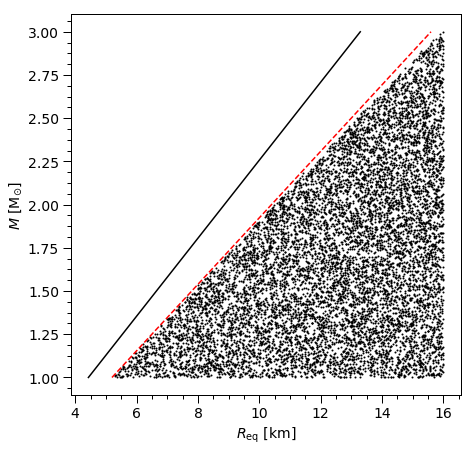

In [77]:
ax = plot_samps(samps,
                likelihood.index('radius'), # we can find the index for __getitem__ magic
                likelihood.index('mass'),
                likelihood.get_param('radius').symbol + ' [km]', # can use symbols like so
                r'$M$ [M$_{\odot}$]') # or manual entry

# the Schwarzschild photon sphere R_eq = 1.5 x r_s(M)
ax.plot(3.0*gravradius(np.linspace(1.0,3.0,100)), np.linspace(1.0,3.0,100), 'k-')

# R_eq = 1.76 x r_s(M)
_ = ax.plot(2.0*1.76*gravradius(np.linspace(1.0,3.0,100)), np.linspace(1.0,3.0,100), 'r--')

Note that the prior support is defined with a constraint that the polar radius $R_{\rm p}(R_{\rm eq}, M, \Omega)\geq 1.76r_{s}(M)$, which is why there is a region devoid of samples between the prior support and the dashed line $R_{\rm eq} = 1.76r_s(M)$. This condition is not necessary though because as of `v0.6`, X-PSI can include higher-order images, with the secondary and tertiary expected to be entirely sufficient in practice.

Let's now plot the hot region (circular spot) colatitudes:

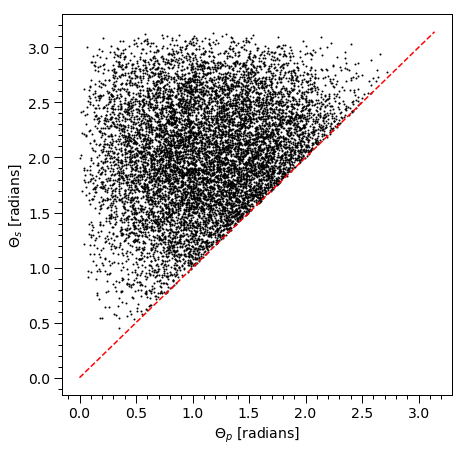

In [78]:
ax = plot_samps(samps,
                likelihood.index('p__super_colatitude'),
                likelihood.index('s__super_colatitude'),
                r'$\Theta_{p}$ [radians]', r'$\Theta_{s}$ [radians]')

# enforce colatitude order to distinguish hot regions as primary and secondary
_ = ax.plot(np.array([0.0,math.pi]), np.array([0.0,math.pi]), 'r--')

Note that the samples, marginalised over other region geometry parameters, are sparser when both hot regions approach the poles because we exclude overlapping configurations from the prior support. This is because the hot regions are by convention defined as disjoint, and cannot merge. If one wanted a more complex hot region, one would not invoke multiple hot regions that are permitted to overlap, but one would instead handle the extra complexity within the ``HotRegion`` class or a subclass.

Let's plot the angular radii of the spots:

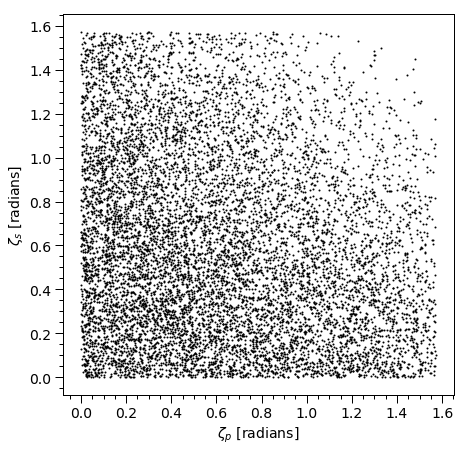

In [79]:
_ = plot_samps(samps,
               likelihood.index('p__super_radius'),
               likelihood.index('s__super_radius'),
               r'$\zeta_{p}$ [radians]',
               r'$\zeta_{s}$ [radians]')

Note that the prior density is greater for hot regions that subtend smaller solid angles at the centre of the star, which also derives from the non-overlapping criterion for prior support.

Finally, let's take a look at the phases:

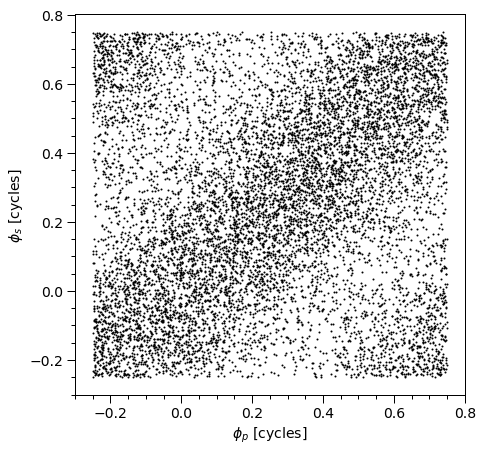

In [80]:
_ = plot_samps(samps,
               likelihood.index('p__phase_shift'),
               likelihood.index('s__phase_shift'),
               r'$\phi_{p}$ [cycles]',
               r'$\phi_{s}$ [cycles]')

Note that again because the hot regions cannot overlap, rarefaction occurs in the vicinity of lines of minimal phase separation. Note that the boundaries are all periodic, so this pattern tesselates. Because we implemented a transformation in our ``CustomPrior`` subclass, we can actually draw the samples and transform them, which is useful in post-processing contexts. We defined the intervals ``[-0.25, 0.75]`` for the inverse sampling so that the posterior mode(s) will not be near a boundary.  The nested sampling algorithm can handle periodic boundaries by defining ``wrapped`` parameters; however, this can be trivially avoided altogether by rough inspection of the phases of the subpulses in the data, which we can see above are at around $-0.1$ and $0.4$ given the respective ground truth (injected) phases of $\phi_{p}=0.0$ and $\phi_{s}=0.025$.

Transformations for the purpose of likelihood evaluation must be handled in the ``inverse_sample`` method of an instance of the ``Prior`` class, but additional transformations that *extend* the parameter vector are written in the ``transform`` method.

If we wanted to transform automatically upon drawing the samples, thereby extending the parameter vectors passed to the ``__call__`` method (so be careful with wrap-around indices when evaluating prior support conditions), we would do the following:

In [81]:
samps_plus_transformed, _ = prior.draw(int(1e4), transform=True)

Drawing samples from the joint prior...
Samples drawn.


We defined a transformation from the hot region centre phases to the phase separation:

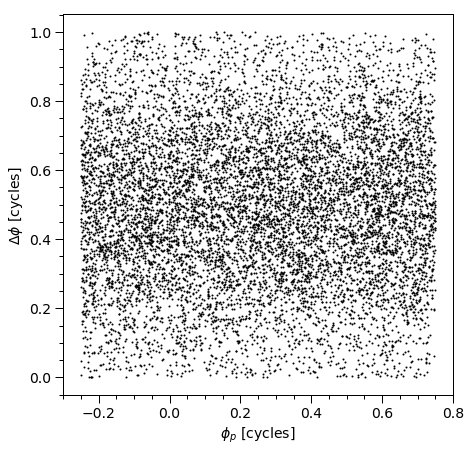

In [82]:
_ = plot_samps(samps_plus_transformed,
               likelihood.index('p__phase_shift'),
               likelihood.prior.index('phase_separation'),
               r'$\phi_{p}$ [cycles]',
               r'$\Delta\phi$ [cycles]')

We can see the rarefaction occurs for $\Delta\phi\sim0.0=1.0$.

The marginal one-dimensional prior distributions are overplotted, by the [PostProcessing](postprocessing.rst) module, with the posterior distributions.

It is recommended to carefully inspect joint prior samples for pairs of parameters before commencing a sampling run, especially if there is a non-trivial constraint equation imposed on the prior support.

## Sampling interface

We have constructed and instantiated both a callable ``likelihood`` object and a callable ``prior`` object. We could proceed, for example, to apply the open-source sampler [emcee](http://emcee.readthedocs.io/en/latest/) to the joint posterior distribution proportional to the product of the (exponentiated) calls to the ``likelihood`` and ``prior`` objects. Note that at least version 3.0.2 is working with Python 2.

### Ensemble MCMC

To prove that the objects constructed above can be fed to the ``emcee`` sampler, let's run a number of iterations using a single Python process. We will initialise the ensemble by drawing from a multivariate Gaussian with mean vector equal to the ground truth (injected) vector. 

In [83]:
std = [1.0,
         0.05,
         1.0,
         0.01,
         0.05,
         0.0025,
         0.01,
         0.05,
         0.05,
         0.01,
         0.01]

runtime_params = {'resume': False,
                  'root_dir': './',
                  'nwalkers': 50,
                  'nsteps': 100,
                  'walker_dist_moments': zip(p, std)} #  if resume then ``None``

for h in hot.objects:
    h.set_phases(num_leaves = 100) # revert to original phase resolution above
    
likelihood.threads = 3
likelihood.reinitialise() # because we played with the object above

# Use MPI=False for testing purposes
backend = xpsi.Sample.ensemble(likelihood, prior,
                               MPI=False, **runtime_params) 

Imported emcee version: 3.0.2

Commencing posterior sampling.


100%|██████████| 100/100 [23:46<00:00, 14.27s/it]


Sampling complete.


In [84]:
# clean up the docs/source directory
#!rm samples.h5; rm -r old_samples

Note that we could also try initialising the ensemble by inverse sampling the joint prior distribution.

Let's quickly plot the evolution of the ensemble Markov chains to prove that the sampling process commenced and is behaving in a somewhat reasonable manner:

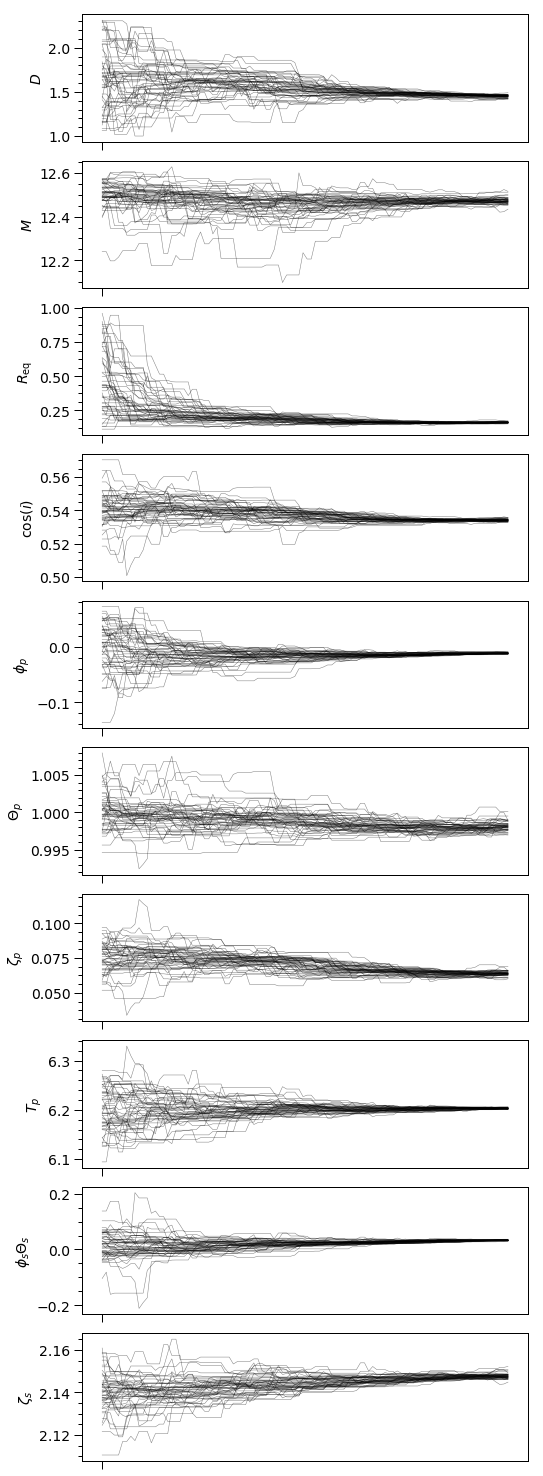

In [85]:
try:
    backend
except NameError:
    import emcee
    backend = emcee.backends.HDFBackend('samples.h5')
    
chain = backend.get_chain()

# These chains plotted were generated using
# v0.2 so the labels here are in a different
# order. The model also had two free
# temperature parameters instead of just one.
# Also, inclination was the parameter, not
# cos(inclination), and the prior was flat
# in inclination, not cos(inclination).
labels = [r'$D$',
          r'$M$',
          r'$R_{\rm eq}$',
          r'$\cos(i)$',
          r'$\phi_{p}$',
          r'$\Theta_{p}$',
          r'$\zeta_{p}$',
          r'$T_{p}$',
          r'$\phi_{s}$'
          r'$\Theta_{s}$',
          r'$\zeta_{s}$']

fig = plt.figure(figsize=(8,32))
          
gs = gridspec.GridSpec(12, 1, hspace=0.15)
          
for i in range(len(labels)):
    ax = plt.subplot(gs[i,0])
    ax.set_ylabel(labels[i])
    for j in range(50):
        plt.plot(chain[:,j,i], 'k-', lw=0.5, alpha=0.5)
    if i < 11:
        ax.tick_params(axis='x', labelbottom=False)
        plt.setp(ax.get_yticklabels()[0], visible=False)
        plt.setp(ax.get_yticklabels()[-1], visible=False)
    else: ax.set_xlabel('Steps')
    veneer((250, 1000), None, ax)

The chains rendered in the documentation were run on a desktop machine in about a day of wall-time. It is visually discernable that the ensemble distribution has not yet evolved to a stationary state: a rigourous application of ensemble MCMC would cover convergence criteria, auto-correlation, and examination of sensitivity to initial conditions and the transition kernel. In fact, based on the analysis with nested sampling on path ``xpsi/examples/default_background``, we know that the posterior mode in the vicinity of the above ensemble is rather non-linear in the space being sampled, so ensemble MCMC may require *many* steps in order to argue for convergence.

### Nested sampling

We interface with the nested sampler MultiNest in a similar manner, by defining some runtime settings, and then passing those settings together with ``likelihood`` and ``prior`` objects to a wrapper from the [Sample](sample.rst) module. We will run the sampler for a specified number (1000) of nested replacements (iterations). Note that the output below was actually generated with the temperature of the secondary hot region as a *free* parameter, resulting in an additional dimension to the model above.

The environment variable ``LD_LIBRARY_PATH`` must be set before launching Jupyter as follows:
    
    $ export LD_LIBRARY_PATH=<path/to/multinest>/lib

Get the parameters that are periodic or *wrapped* to inform MultiNest of boundary properties:

In [83]:
wrapped_params = [0]*len(likelihood)
wrapped_params[likelihood.index('p__phase_shift')] = 1
wrapped_params[likelihood.index('s__phase_shift')] = 1

In [85]:
runtime_params = {'resume': False,
                  'importance_nested_sampling': False,
                  'multimodal': False,
                  'n_clustering_params': None,
                  'outputfiles_basename': './run/run', # make ./run directory manually
                  'n_iter_before_update': 50,
                  'n_live_points': 50, #100
                  'sampling_efficiency': 0.8,
                  'const_efficiency_mode': False,
                  'wrapped_params': wrapped_params,
                  'evidence_tolerance': 0.5,
                  'max_iter': 100, # 10000 # manual termination condition for short test
                  'verbose': True}

for h in hot.objects:
    h.set_phases(num_leaves = 100)
    
likelihood.threads = 3
likelihood.reinitialise()
likelihood.clear_cache()

# inform source code that parameter objects updated when inverse sampling
likelihood.externally_updated = True

p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2]

# let's require that checks pass before starting to sample
check_kwargs = dict(hypercube_points = None,
                    physical_points = p, # externally_updated preserved
                    loglikelihood_call_vals = [-26713.6136777], # from above
                    rtol_loglike = 1.0e-6) # choose a tolerance

# note that mutual refs are already stored in the likelihood and prior
# objects to facilitate communication externally of the sampling process
xpsi.Sample.nested(likelihood, prior, check_kwargs, **runtime_params)

Checking likelihood and prior evaluation before commencing sampling...
Cannot import ``allclose`` function from NumPy.
Using fallback implementation...
Checking closeness of likelihood arrays:
-2.67136014e+04 | -2.67136137e+04 .....
Closeness evaluated.
Log-likelihood value checks passed on root process.
Checks passed.
Commencing integration...
Estimating fractional hypervolume of the unit hypercube with finite prior density:
Requiring 1E+03 draws from the prior support for Monte Carlo estimation...
Drawing samples from the joint prior...
Samples drawn.
The support occupies an estimated 11.9% of the hypervolume within the unit hypercube...
Fractional hypervolume estimated.
Sampling efficiency set to: 6.6952.
  analysing data from ./run/run.txt
Integration completed.


The verbose output of the MultiNest program is by default directed to the host terminal session. Instead of trying to redirect that output to that of the above cell, we simply copy and paste the output from the terminal below. For the purpose of illustration, this output was for a 12-dimensional model variant (as for the emcee plot above but using a longer test run).

    *****************************************************
    MultiNest v3.11
    Copyright Farhan Feroz & Mike Hobson
    Release Apr 2018

    no. of live points =  100

    dimensionality =   12
    *****************************************************
    Starting MultiNest
    generating live points
     live points generated, starting sampling
    Acceptance Rate:                        0.724638
    Replacements:                                100
    Total Samples:                               138
    Nested Sampling ln(Z):            **************
    Acceptance Rate:                        0.649351
    Replacements:                                150
    Total Samples:                               231
    Nested Sampling ln(Z):            -116670.287917
    Acceptance Rate:                        0.569801
    Replacements:                                200
    Total Samples:                               351
    Nested Sampling ln(Z):            -115291.669431
    Acceptance Rate:                        0.449640
    Replacements:                                250
    Total Samples:                               556
    Nested Sampling ln(Z):            -108499.449911
    Acceptance Rate:                        0.408719
    Replacements:                                300
    Total Samples:                               734
    Nested Sampling ln(Z):             -95430.022790
    Acceptance Rate:                        0.367261
    Replacements:                                350
    Total Samples:                               953
    Nested Sampling ln(Z):             -77360.112633
    Acceptance Rate:                        0.319744
    Replacements:                                400
    Total Samples:                              1251
    Nested Sampling ln(Z):             -66119.380404
    Acceptance Rate:                        0.263930
    Replacements:                                450
    Total Samples:                              1705
    Nested Sampling ln(Z):             -57607.930990
    Acceptance Rate:                        0.213675
    Replacements:                                500
    Total Samples:                              2340
    Nested Sampling ln(Z):             -53505.956949
    Acceptance Rate:                        0.173119
    Replacements:                                550
    Total Samples:                              3177
    Nested Sampling ln(Z):             -50428.177797
    Acceptance Rate:                        0.147893
    Replacements:                                600
    Total Samples:                              4057
    Nested Sampling ln(Z):             -47108.755667
    Acceptance Rate:                        0.132653
    Replacements:                                650
    Total Samples:                              4900
    Nested Sampling ln(Z):             -43437.007007
    Acceptance Rate:                        0.125381
    Replacements:                                700
    Total Samples:                              5583
    Nested Sampling ln(Z):             -39888.092691
    Acceptance Rate:                        0.113533
    Replacements:                                750
    Total Samples:                              6606
    Nested Sampling ln(Z):             -36841.337131
    Acceptance Rate:                        0.100251
    Replacements:                                800
    Total Samples:                              7980
    Nested Sampling ln(Z):             -34450.919514
    Acceptance Rate:                        0.088450
    Replacements:                                850
    Total Samples:                              9610
    Nested Sampling ln(Z):             -32545.531967
    Acceptance Rate:                        0.080121
    Replacements:                                900
    Total Samples:                             11233
    Nested Sampling ln(Z):             -31270.147897
    Acceptance Rate:                        0.069674
    Replacements:                                950
    Total Samples:                             13635
    Nested Sampling ln(Z):             -30103.155016
    Acceptance Rate:                        0.064201
    Replacements:                               1000
    Total Samples:                             15576
    Nested Sampling ln(Z):             -29365.169148
    Acceptance Rate:                        0.058427
    Replacements:                               1050
    Total Samples:                             17971
    Nested Sampling ln(Z):             -28879.280235
     ln(ev)=  -28879.280235090871      +/-                       NaN
     Total Likelihood Evaluations:        17971
     Sampling finished. Exiting MultiNest

## Synthesis

In this notebook thus far we have not generated sythetic data. However, we did condition on synthetic data. Below we outline how that data was generated.

### Background

The background radiation field incident on the model instrument for the purpose of generating synthetic data was a time-invariant powerlaw spectrum, and was transformed into a count-rate in each output channel using the response matrix for synthetic data generation. We would reproduce this background here by writing a custom subclass as follows.

In [102]:
class CustomBackground(xpsi.Background):
    """ The background injected to generate synthetic data. """

    def __init__(self, bounds=None, value=None):
        
        # first the parameters that are fundemental to this class
        doc = """
        Powerlaw spectral index.
        """
        index = xpsi.Parameter('powerlaw_index',
                                strict_bounds = (-3.0, -1.01),
                                bounds = bounds,
                                doc = doc,
                                symbol = r'$\Gamma$',
                                value = value)
        
        super(CustomBackground, self).__init__(index)

    def __call__(self, energy_edges, phases):
        """ Evaluate the incident background field. """
        
        G = self['powerlaw_index']

        temp = np.zeros((energy_edges.shape[0] - 1, phases.shape[0]))

        temp[:,0] = (energy_edges[1:]**(G + 1.0) - energy_edges[:-1]**(G + 1.0)) / (G + 1.0)

        for i in range(phases.shape[0]):
            temp[:,i] = temp[:,0]

        self._incident_background = temp

Note that the analytic background is integrated over energy intervals, as required by a ``Signal`` instance, which would then straightforwardly apply the model instrument response to the background.

We can now construct and instantiate a ``background`` object. The base clase ``xpsi.Background`` is inherited from the [ParameterSubspace](parameterSubspace.rst#xpsi.ParameterSubspace.ParameterSubspace) ABC. We therefore need to specify the number of background parameters, and define the hard bounds on those parameters; in this case we have only a single parameter, the powerlaw index.

We would then instantiate as follows:

In [103]:
background = CustomBackground(bounds=(None, None)) # use strict bounds, but do not fix/derive

Creating parameter:
    > Named "powerlaw_index" with bounds [-3.000e+00, -1.010e+00].
    > Powerlaw spectral index.


### Data format

We are also in need of a simpler data object.

In [104]:
class SynthesiseData(xpsi.Data):
    """ Custom data container to enable synthesis. """
    
    def __init__(self, channels, phases, first, last):
        
        self.channels = channels
        self._phases = phases
        
        try:
            self._first = int(first)
            self._last = int(last)
        except TypeError:
            raise TypeError('The first and last channels must be integers.')
        if self._first >= self._last:
            raise ValueError('The first channel number must be lower than the '
                             'the last channel number.')

Instantiate:

In [105]:
_data = SynthesiseData(np.arange(20,201), np.linspace(0.0, 1.0, 33), 0, 180)

Setting channels for event data...
Channels set.


### Custom method

We are in need of a ``synthesise`` method, which in this implementation wraps an extension module. Let's check what the extension module offers:

In [106]:
from xpsi.tools.synthesise import synthesise_given_total_count_number as _synthesise

In [107]:
_synthesise?

In [108]:
def synthesise(self,
               require_source_counts,
               require_background_counts,
               name='synthetic',
               directory='./data',
               **kwargs):
        """ Synthesise data set.

        """
        self._expected_counts, synthetic, _, _ = _synthesise(self._data.phases,
                                            require_source_counts,
                                            self._signals,
                                            self._phases,
                                            self._shifts,
                                            require_background_counts,
                                            self._background.registered_background)
        try:
            if not os.path.isdir(directory):
                os.mkdir(directory)
        except OSError:
            print('Cannot create write directory.')
            raise

        np.savetxt(os.path.join(directory, name+'_realisation.dat'),
                   synthetic,
                   fmt = '%u')

        self._write(self.expected_counts,
                    filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                    fmt = '%.8e')

        self._write(synthetic,
                    filename = os.path.join(directory, name+'_realisation_hreadable.dat'),
                    fmt = '%u')

def _write(self, counts, filename, fmt):
    """ Write to file in human readable format. """

    rows = len(self._data.phases) - 1
    rows *= len(self._data.channels)

    phases = self._data.phases[:-1]
    array = np.zeros((rows, 3))

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            array[i*len(phases) + j,:] = self._data.channels[i], phases[j], counts[i,j]

    np.savetxt(filename, array, fmt=['%u', '%.6f'] + [fmt])

Add unbound methods:

In [109]:
CustomSignal.synthesise = synthesise
CustomSignal._write = _write

Instantiate, and reconfigure the likelihood object:

In [110]:
signal = CustomSignal(data = _data,
                        instrument = NICER,
                        background = background,
                        interstellar = None,
                        prefix='NICER')

for h in hot.objects:
    h.set_phases(num_leaves = 100)
    
likelihood = xpsi.Likelihood(star = star, signals = signal, threads=1)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].


### Synthesise

We proceed to synthesise. First we set an environment variable to seed the random number generator being called:

In [111]:
%env GSL_RNG_SEED=0

env: GSL_RNG_SEED=0


Check write path:

In [112]:
!pwd

/home/tuomo/xpsi/xpsi_group/xpsi/docs/source


In [113]:
likelihood

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
s__phase_shift: The phase of the hot region, a periodic parameter [cycles].
s__super_colatitude: The colatitude of the centre of the superseding region [radians].
s__super_radius: The angular radius of the (circular) superseding region [radians].
NICER__powerlaw_index: Powerlaw spectral index.

In [114]:
p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2,
     -2.0]

NICER_kwargs = dict(require_source_counts=2.0e6,
                     require_background_counts=2.0e6,
                     name='new_synthetic',
                     directory='./data')

likelihood.synthesise(p, force=True, NICER=NICER_kwargs) # SEED=0

Exposure time: 984282.608809 [s]
Background normalisation: 1.89132786e-05


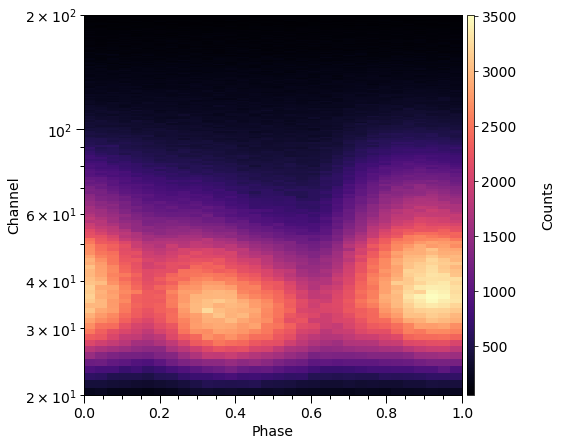

In [115]:
plot_one_pulse(np.loadtxt('data/new_synthetic_realisation.dat', dtype=np.double), _data.phases)

Check we have generated the same count numbers, given the same seed and resolution settings:

In [116]:
diff = data.counts - np.loadtxt('data/new_synthetic_realisation.dat', dtype=np.double)
(diff != 0.0).any()

True

The output should be ``False`` if there is no difference in the expectations of the Poisson-distribution random variables, as was the case for ``xpsi.__version__ <= v0.5``. Now however, because of slight tweaks to the signal integrators, small differences manifest, especially when hot region visibility gets truncated at the stellar limb. The major cause of this difference is because we swap to the Akima Periodic splines phase interpolants from GSL. Previously we invoked the non-periodic Steffen spline interpolants (the important feature for comparison being that minima and maxima in the interpolant can only occur at spline nodes), also from GSL. The aim in doing this is to increase accuracy near the signal maxima and minima, whilst potentially sacrificing some accuracy when interpolating a curve that is truncated at zero due to a radiating element going out of visibility, or in the context of an extended radiating region, that region going fully out of visibility.

The change in the log-likelihood was small, at the $\sim5\times10^{-5}\%$ level, but let's plot the difference between the expectations:

In [118]:
x = np.loadtxt('../../examples/examples_modeling_tutorial/model_data/example_synthetic_expected_hreadable.dat')
y = np.loadtxt('data/new_synthetic_expected_hreadable.dat')

xx = np.zeros(data.counts.shape)
yy = np.zeros(data.counts.shape)

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        xx[i,j] = x[i*32 + j,-1]
        yy[i,j] = y[i*32 + j,-1]

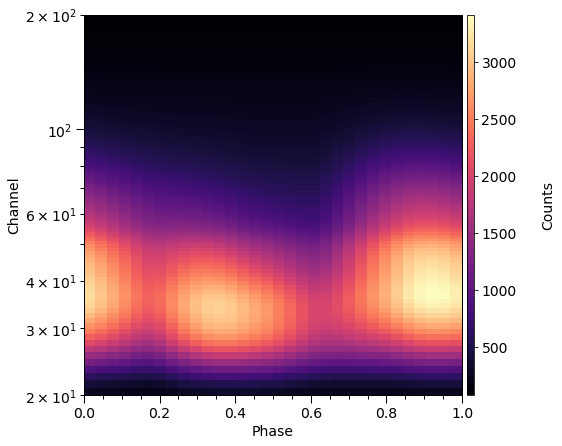

In [119]:
plot_one_pulse(yy, _data.phases)

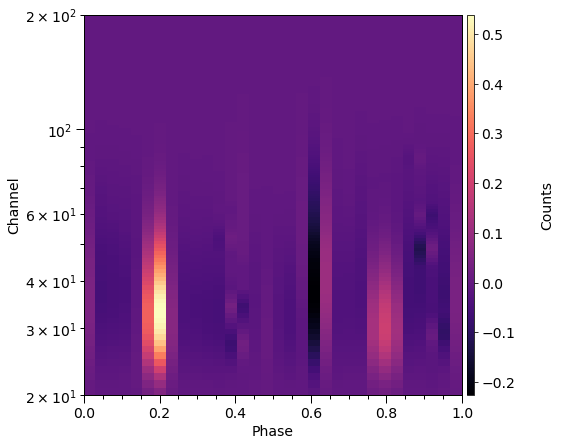

In [120]:
plot_one_pulse(yy-xx, _data.phases)

And normalised by the root-variance:

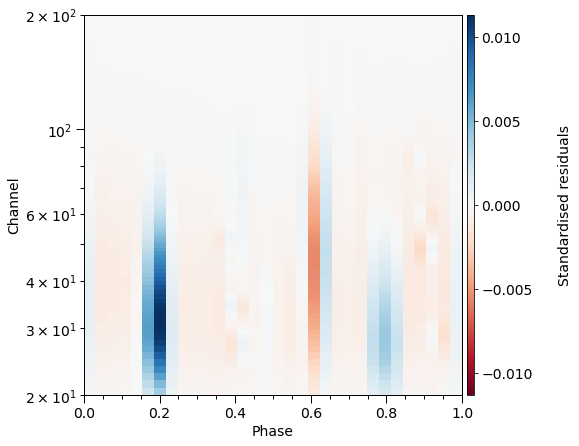

In [121]:
_r = (yy-xx)/np.sqrt(yy)
plot_one_pulse(_r, _data.phases,
               'Standardised residuals',
               cmap=cm.RdBu,
               vmin=-np.max(np.fabs(_r)),
               vmax=np.max(np.fabs(_r)))

The difference between realisations is far larger than one count (which is what might be expected in some cases due to discreteness of the Poisson probability mass function) for many intervals, despite the small change in the expectation:

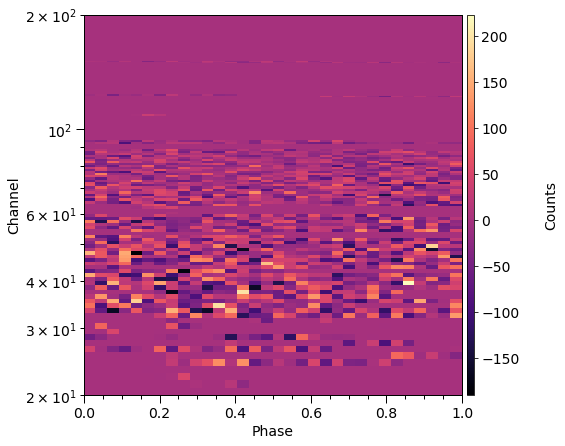

In [122]:
plot_one_pulse(diff, _data.phases)

I'm actually unsure why a such small changes in the Poisson-distributed random variable expectations yields such large differences in the random variates for the same GSL RNG seed. For a substantial subset of elements, the random variates *are* equal, and that is not always where the difference in expectations is zero or relatively small. I consider this an open problem: please get in touch if you happen to read this and you have some insight you can share!

Here is the distribution of standardised variate residuals, for the realisation generated by this notebook, bearing in mind noise and that the Poisson distribution deparature from Gaussianity for lower expectations:

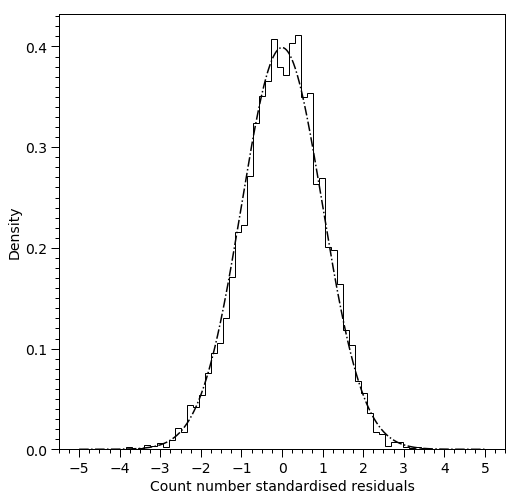

In [123]:
plt.figure(figsize=(8,8))
ax = plt.gcf().add_subplot(111)

variates = (yy - np.loadtxt('data/new_synthetic_realisation.dat', dtype=np.double))/np.sqrt(yy)

_ = ax.hist(variates.flatten(),
             bins=50,
             density=True,
             histtype='step',
             color='k',
             lw=1.0)

_x = np.linspace(-5.0,5.0,1000)
ax.plot(_x, np.exp(-0.5 * _x**2.0)/np.sqrt(2.0 * math.pi), 'k-.')

ax.set_xlabel('Count number standardised residuals')
ax.set_ylabel('Density')
veneer((0.25, 1.0), (0.01, 0.1), ax)

And there are no discernable correlations:

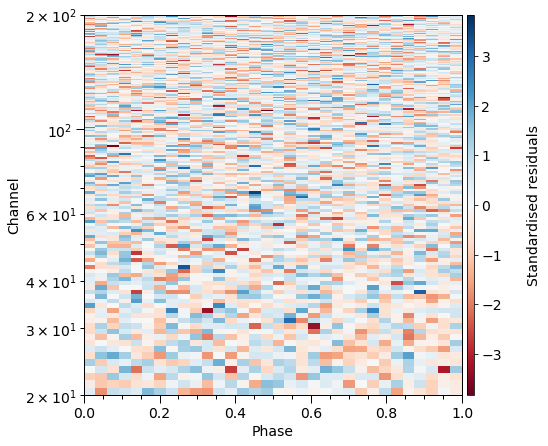

In [124]:
plot_one_pulse(variates, _data.phases,
               'Standardised residuals',
               cmap=cm.RdBu,
               vmin=-np.max(np.fabs(variates)),
               vmax=np.max(np.fabs(variates)))

If we switch back to a Steffen phase spline, the issue does not entirely disappear, but the differences are seemingly too small to affect random number generation.

In [125]:
xpsi.set_phase_interpolant('Steffen')

In [126]:
likelihood.synthesise(p, force=True, NICER=NICER_kwargs) # SEED=0

Exposure time: 984307.621509 [s]
Background normalisation: 1.89127980e-05


Note the small difference here in exposure time and background normalisation.

In [127]:
z = np.loadtxt('data/new_synthetic_expected_hreadable.dat')
zz = np.zeros(data.counts.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i,j] = z[i*32 + j,-1]

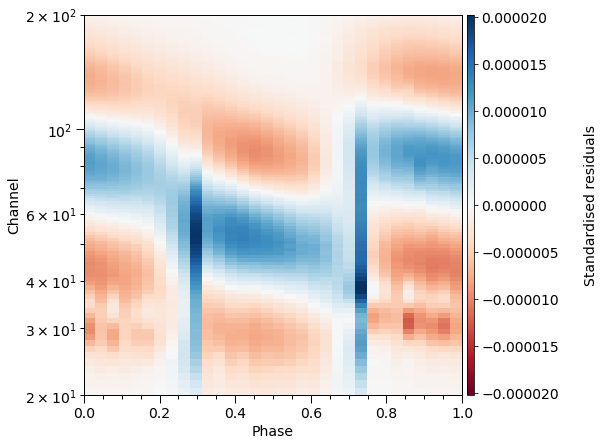

In [128]:
_r = (zz-xx)/np.sqrt(zz)
plot_one_pulse(_r, _data.phases,
               'Standardised residuals',
               cmap=cm.RdBu,
               vmin=-np.max(np.fabs(_r)),
               vmax=np.max(np.fabs(_r)))

In [129]:
diff = data.counts - np.loadtxt('data/new_synthetic_realisation.dat', dtype=np.double)
(diff != 0.0).any()

False

## Summary

In this notebook we constructed a model including a likelihood and prior objects. We also looked at the sampling interface, and concluded by synthesising the pre-prepared data set that was loaded at the beginning of the notebook.